## Recommendation List Bayesian Modeling

This notebook builds out the core model for recommendation list inference.

## Setup

In [1]:
library(grid)
library(gtable)
library(xtable)
library(rstan)
library(loo)
library(psych)
library(iterators)
library(foreach)
library(assertthat)
library(tidyverse)

Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.17.3, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
This is loo version 1.1.0

Attaching package: ‘psych’

The following object is masked from ‘package:rstan’:

    lookup

The following objects are masked from ‘package:ggplot2’:

    %+%, alpha

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  1.4.1     ✔ purrr   0.2.4
✔ tidyr   0.7.2     ✔ dplyr   0.7.4
✔ readr   1.1.1     ✔ stringr 1.2.0
✔ tibble  1.4.1     ✔ forcats 0.2.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ psych::%+%()        masks ggplot2::%+%()
✖ purrr::accumulate() masks foreach::accumulate()
✖ psych::alpha()      masks ggplot2::alpha()
✖ tidyr::extract(

In [2]:
if (file.exists("build/RecListModels.rda")) {
    message("pre-loading data")
    load("build/RecListModels.rda")
}

pre-loading data


In [3]:
options(mc.cores=parallel::detectCores())
rstan_options(auto_write=TRUE)

In [4]:
options(repr.matrix.max.rows=20)
options(repr.plot.height=5)

In [5]:
source("utils.R")

## Load User Profiles and Background Data

We have author-gender information for a bunch of books:

In [5]:
author_gender = read_csv("build/author-gender.csv")
head(author_gender)

Parsed with column specification:
cols(
  bookID = col_integer(),
  authorGender = col_character()
)


bookID,authorGender
101891138,female
113484902,male
105203065,unknown
100940351,male
206535758,unknown
110621222,unknown


Load the implicit ratings for the implicit feedback user sample.

In [6]:
bx_implicit_ratings = read_csv("build/sample-ratings-implicit.csv", guess_max = 10000)

Parsed with column specification:
cols(
  userID = col_integer(),
  bookID = col_integer(),
  rating = col_double()
)


Load the explicit ratings for the explicit feedback user sample;

In [7]:
bx_explicit_ratings = read_csv("build/sample-ratings-explicit.csv", guess_max = 10000)

Parsed with column specification:
cols(
  userID = col_integer(),
  bookID = col_integer(),
  rating = col_double()
)


In [8]:
az_ratings = read_csv("build/sample-ratings-amazon.csv", guess_max = 10000)

Parsed with column specification:
cols(
  userID = col_integer(),
  bookID = col_integer(),
  rating = col_double()
)


And merge them together

In [9]:
user_ratings =
    bind_rows(BXA = bx_implicit_ratings,
              BXE = bx_explicit_ratings,
              AZ = az_ratings,
              .id="Set") %>%
    rename(User=userID, Book=bookID)
head(user_ratings)

Set,User,Book,rating
BXA,272,100058368,8
BXA,272,102084359,0
BXA,272,104805048,7
BXA,272,106179058,7
BXA,272,109127868,0
BXA,272,110609828,0


For context, summarize the entire rating database.

Load recommendations.

In [10]:
bx_implicit_recs = read_csv("build/eval-recommendation-implicit.csv") %>%
    mutate(Algorithm = sub("-Implicit", "", Algorithm))
head(bx_implicit_recs)

Parsed with column specification:
cols(
  DataSet = col_character(),
  Algorithm = col_character(),
  User = col_integer(),
  Rank = col_integer(),
  Item = col_integer(),
  Score = col_double()
)


DataSet,Algorithm,User,Rank,Item,Score
null,Popularity,262660,1,109368878,1.0000000
null,Popularity,262660,2,100004153,0.9999966
null,Popularity,262660,3,100858196,0.9999932
null,Popularity,262660,4,101777561,0.9999899
null,Popularity,262660,5,107007538,0.9999865
null,Popularity,248033,1,109368878,1.0000000


In [11]:
bx_explicit_recs = read_csv("build/eval-recommendation-explicit.csv")
head(bx_explicit_recs)

Parsed with column specification:
cols(
  DataSet = col_character(),
  Algorithm = col_character(),
  User = col_integer(),
  Rank = col_integer(),
  Item = col_integer(),
  Score = col_double()
)


DataSet,Algorithm,User,Rank,Item,Score
null,Popularity,93370,1,100858196,1.0000000
null,Popularity,47974,1,100858196,1.0000000
null,Popularity,47974,2,100004153,0.9999938
null,Popularity,191671,1,100858196,1.0000000
null,Popularity,55490,1,100858196,1.0000000
null,Popularity,55490,2,100004153,0.9999938


In [12]:
az_explicit_recs = read_csv("build/eval-recommendation-explicit-amazon.csv")
head(az_explicit_recs)

Parsed with column specification:
cols(
  DataSet = col_character(),
  Algorithm = col_character(),
  User = col_integer(),
  Rank = col_integer(),
  Item = col_integer(),
  Score = col_double()
)


DataSet,Algorithm,User,Rank,Item,Score
null,Popularity,5201796,1,108177024,1.0000000
null,Popularity,5201796,2,919370894,0.9999996
null,Popularity,5201796,3,110263744,0.9999991
null,Popularity,5201796,4,103608999,0.9999987
null,Popularity,5201796,5,101819869,0.9999983
null,Popularity,5201796,6,919510924,0.9999978


In [13]:
az_implicit_recs = read_csv("build/eval-recommendation-implicit-amazon.csv") %>%
    mutate(Algorithm = gsub("-Implicit", "", Algorithm))

Parsed with column specification:
cols(
  DataSet = col_character(),
  Algorithm = col_character(),
  User = col_integer(),
  Rank = col_integer(),
  Item = col_integer(),
  Score = col_double()
)


In [14]:
recs = bind_rows(BXA = bx_implicit_recs,
                 BXE = bx_explicit_recs,
                 AZ = bind_rows(az_explicit_recs,
                                mutate(az_implicit_recs, Algorithm=paste(Algorithm, "I", sep="-"))),
                 .id="Set") %>%
    select(Set, Algorithm, User, Rank, Book=Item, Score) %>%
    filter(Rank <= 50, !startsWith(Algorithm, "Popularity"), Algorithm != 'Bias')
head(recs)

Set,Algorithm,User,Rank,Book,Score
BXA,UserUser,181830,1,101848697,0.6137098
BXA,UserUser,181830,2,102590737,0.5744267
BXA,UserUser,181830,3,101777561,0.5412320
BXA,UserUser,181830,4,106677378,0.4863934
BXA,UserUser,181830,5,114269108,0.4846798
BXA,UserUser,181830,6,103741233,0.4677265


In [15]:
lists = bind_rows(user_ratings %>% mutate(Algorithm="Profile") %>% select(Set, User, Algorithm, Book),
                  recs %>% select(Set, User, Algorithm, Rank, Book)) %>%
    mutate(Algorithm = ordered(Algorithm, levels=c("Profile", sort(discard(unique(Algorithm), ~ . == "Profile"))))) %>%
    left_join(select(author_gender, Book=bookID, AuthorGender=authorGender)) %>%
    mutate(Set = as.factor(Set),
           Gender = ordered(if_else(is.na(AuthorGender), 'unlinked', AuthorGender), 
                            levels=c("female", "male", "ambiguous", "unknown", "unlinked")),
           Algorithm=recode(Algorithm, FunkSVD='MF', `FunkSVD-I`='MF-I')) %>%
    select(-AuthorGender)
head(lists)

Joining, by = "Book"


Set,User,Algorithm,Book,Rank,Gender
BXA,272,Profile,100058368,NA,ambiguous
BXA,272,Profile,102084359,NA,female
BXA,272,Profile,104805048,NA,ambiguous
BXA,272,Profile,106179058,NA,male
BXA,272,Profile,109127868,NA,female
BXA,272,Profile,110609828,NA,male


## Nonpersonalized Recommendations

In [16]:
bxa_data = read_csv("build/bx-implicit.csv", guess_max = 10000)

Parsed with column specification:
cols(
  userID = col_integer(),
  bookID = col_integer(),
  rating = col_double()
)


In [17]:
bxe_data = read_csv("build/bx-ratings.csv", guess_max = 10000)

Parsed with column specification:
cols(
  userID = col_integer(),
  bookID = col_integer(),
  rating = col_double()
)


In [18]:
az_data = read_csv("build/az-ratings.csv", guess_max = 10000)

Parsed with column specification:
cols(
  userID = col_integer(),
  bookID = col_integer(),
  rating = col_double()
)


In [19]:
bxa_item_stats = bxa_data %>%
    group_by(bookID) %>%
    summarize(count=n())
head(bxa_item_stats)

bookID,count
100000101,1
100000287,1
100000506,1
100000934,1
100001178,20
100001235,200


In [20]:
bxe_mean = mean(bxe_data$rating)
bxe_item_stats = bxe_data %>%
    group_by(bookID) %>%
    summarize(count=n(), avg=(sum(rating) + 5) / (n() + 5))
head(bxe_item_stats)

bookID,count,avg
100000287,1,2.166667
100000506,1,1.666667
100000934,1,2.166667
100001178,12,5.647059
100001235,101,7.830189
100001671,1,2.000000


In [21]:
az_item_stats = az_data %>%
    group_by(bookID) %>%
    summarize(count=n(), avg=(sum(rating) + 5) / (n() + 5))
head(az_item_stats)

bookID,count,avg
100000007,1,1.666667
100000064,4,2.444444
100000130,4,2.666667
100000165,13,2.944444
100000239,2,1.857143
100000291,1,1.666667


Combine into top statistics, and then pick the top 50 for each method.

In [22]:
item_stats = bind_rows(BXA=bxa_item_stats, BXE=bxe_item_stats, AZ=az_item_stats, .id='Set') %>%
    mutate(rkey=runif(n(), 0, 1))

In [23]:
pop_items = item_stats %>% group_by(Set) %>%
    top_n(50, count + rkey) %>%
    select(-rkey)
pop_items

Set,bookID,count,avg
BXA,100004153,1505,NA
BXA,100007208,767,NA
BXA,100055770,817,NA
BXA,100058368,534,NA
BXA,100151275,534,NA
BXA,100338195,831,NA
BXA,100338652,813,NA
BXA,100351414,593,NA
BXA,100466327,650,NA
BXA,100536022,566,NA


In [24]:
pop_item_stats = pop_items %>% left_join(author_gender) %>%
    transmute(bookID, gender=coalesce(authorGender, 'unknown')) %>%
    group_by(Set, gender) %>%
    summarize(nbooks=n()) %>%
    spread(gender, nbooks) %>%
    mutate(Total=unknown+female+male,
           PropKnown=(Total - unknown)/Total,
           PropFemale=female / (female + male))
pop_item_stats

Joining, by = "bookID"
Adding missing grouping variables: `Set`


Set,ambiguous,female,male,unknown,Total,PropKnown,PropFemale
AZ,2,6,10,32,48,0.3333333,0.3750000
BXA,5,17,28,NA,NA,NA,0.3777778
BXE,4,19,27,NA,NA,NA,0.4130435


In [25]:
hi_items = item_stats %>% group_by(Set) %>%
    top_n(50, avg) %>%
    select(-rkey)
hi_items

Set,bookID,count,avg
BXE,100018679,192,8.203046
BXE,100034172,132,8.343066
BXE,100055770,429,8.339862
BXE,100244760,219,8.526786
BXE,100298591,86,8.296703
BXE,100337996,192,8.190355
BXE,100338652,384,8.170951
BXE,100351414,362,8.723433
BXE,100386306,229,8.378205
BXE,100594560,42,8.361702


In [26]:
hi_item_stats = hi_items %>% left_join(author_gender) %>%
    transmute(bookID, gender=coalesce(authorGender, 'unknown')) %>%
    group_by(Set, gender) %>%
    summarize(nbooks=n()) %>%
    spread(gender, nbooks) %>%
    mutate(Total=unknown+female+male,
           PropKnown=(Total - unknown)/Total,
           PropFemale=female / (female + male))
hi_item_stats

Joining, by = "bookID"
Adding missing grouping variables: `Set`


Set,ambiguous,female,male,unknown,Total,PropKnown,PropFemale
AZ,NA,4,6,40,50,0.20,0.4000000
BXE,10,10,28,2,40,0.95,0.2631579


## Summarize Recommendation Lists

We will integrate user ratings with book information and summarize, so we can start to see what things look like.

In [27]:
list_info = lists %>%
    group_by(Set, User, Algorithm) %>%
    summarize(Count=n(),
              Linked=sum(Gender != 'unlinked'),
              Ambiguous = sum(Gender == 'ambiguous'),
              NMale = sum(Gender == 'male'),
              NFemale = sum(Gender == 'female')) %>%
    ungroup() %>%
    mutate(Known = NMale + NFemale,
           PropFemale = NFemale/Known,
           PropKnown = Known/Count)
list_info

Set,User,Algorithm,Count,Linked,Ambiguous,NMale,NFemale,Known,PropFemale,PropKnown
AZ,1306,Profile,7,6,0,5,0,5,0.0000000,0.7142857
AZ,1306,MF,50,29,2,10,10,20,0.5000000,0.4000000
AZ,1306,MF-I,50,19,1,2,1,3,0.3333333,0.0600000
AZ,1306,ItemItem,50,38,0,15,4,19,0.2105263,0.3800000
AZ,1306,ItemItem-I,50,41,0,17,5,22,0.2272727,0.4400000
AZ,1306,PF,50,25,1,17,6,23,0.2608696,0.4600000
AZ,1306,PF-I,50,24,2,11,7,18,0.3888889,0.3600000
AZ,1306,UserUser-I,50,36,0,18,6,24,0.2500000,0.4800000
AZ,8296,Profile,9,7,0,4,3,7,0.4285714,0.7777778
AZ,8296,MF,50,28,1,11,9,20,0.4500000,0.4000000


How many users?

In [93]:
list_item_counts = lists %>%
    group_by(Set, Algorithm) %>%
    summarize(Total = n(), Distinct = n_distinct(Book), Users=n_distinct(User)) %>%
    ungroup() %>%
    mutate(Set = if_else(Set == "AZ" & endsWith(as.character(Algorithm), "-I"), "AZI", as.character(Set)),
           Algorithm=gsub("-I$", "", Algorithm),
           FracDistinct=Distinct / Total)
list_item_counts

Set,Algorithm,Total,Distinct,Users,FracDistinct
AZ,Profile,31218,27525,1000,0.8817029
AZ,MF,50000,651,1000,0.0130200
AZI,MF,50000,164,1000,0.0032800
AZ,ItemItem,49052,22360,999,0.4558428
AZI,ItemItem,49268,33363,999,0.6771738
AZ,PF,50000,3538,1000,0.0707600
AZI,PF,50000,2746,1000,0.0549200
AZ,UserUser,46904,25853,939,0.5511897
AZI,UserUser,50000,15343,1000,0.3068600
BXA,Profile,52902,35187,1000,0.6651355


In [94]:
list_item_counts %>%
    select(Set, Algorithm, Users) %>%
    spread(Set, Users) %>%
    select(Algorithm, BXA, BXE, AZI, AZ)

Algorithm,BXA,BXE,AZI,AZ
ItemItem,1000,997,999,999
MF,1000,1000,1000,1000
PF,1000,1000,1000,1000
Profile,1000,1000,NA,1000
UserUser,1000,988,1000,939


How many unique books are in each thing?

In [96]:
list_item_counts %>%
    select(Set, Algorithm, Distinct) %>%
    spread(Algorithm, Distinct)

Set,ItemItem,MF,PF,Profile,UserUser
AZ,22360,651,3538,27525,25853
AZI,33363,164,2746,NA,15343
BXA,21282,140,1506,35187,6007
BXE,10174,264,4105,24913,6235


In [97]:
list_item_counts %>%
    mutate(FracDistinct = Distinct / Total) %>%
    select(Set, Algorithm, FracDistinct) %>%
    spread(Algorithm, FracDistinct)

Set,ItemItem,MF,PF,Profile,UserUser
AZ,0.4558428,0.01302,0.07076,0.8817029,0.5511897
AZI,0.6771738,0.00328,0.05492,NA,0.3068600
BXA,0.4260490,0.00280,0.03012,0.6651355,0.1202554
BXE,0.2043670,0.00528,0.08210,0.7359388,0.1266196


In [112]:
lic_tab = list_item_counts %>% select(-Total) %>%
    gather("Metric", "Value", Users, Distinct, FracDistinct) %>%
    mutate(Set=recode(Set, BXA="A.BXA", BXE="B.BXE", AZI="C.AZI", AZ="D.AZE"),
           Metric=recode(Metric, Users="A.Users", Distinct="B.Distinct", FracDistinct="C.FracDistinct"),
           Algorithm=recode_factor(Algorithm, .ordered=TRUE,
                                   Profile="Profile",
                                   UserUser="UserUser",
                                   ItemItem="ItemItem",
                                   MF="MF",
                                   PF="PF")) %>%
    unite(Column, Set, Metric) %>%
    spread(Column, Value)
lic_tab

Algorithm,A.BXA_A.Users,A.BXA_B.Distinct,A.BXA_C.FracDistinct,B.BXE_A.Users,B.BXE_B.Distinct,B.BXE_C.FracDistinct,C.AZI_A.Users,C.AZI_B.Distinct,C.AZI_C.FracDistinct,D.AZE_A.Users,D.AZE_B.Distinct,D.AZE_C.FracDistinct
Profile,1000,35187,0.6651355,1000,24913,0.7359388,NA,NA,NA,1000,27525,0.8817029
UserUser,1000,6007,0.1202554,988,6235,0.1266196,1000,15343,0.3068600,939,25853,0.5511897
ItemItem,1000,21282,0.4260490,997,10174,0.2043670,999,33363,0.6771738,999,22360,0.4558428
MF,1000,140,0.0028000,1000,264,0.0052800,1000,164,0.0032800,1000,651,0.0130200
PF,1000,1506,0.0301200,1000,4105,0.0821000,1000,2746,0.0549200,1000,3538,0.0707600


### Link Coverage

What is the coverage over *ratings and recommendations*?

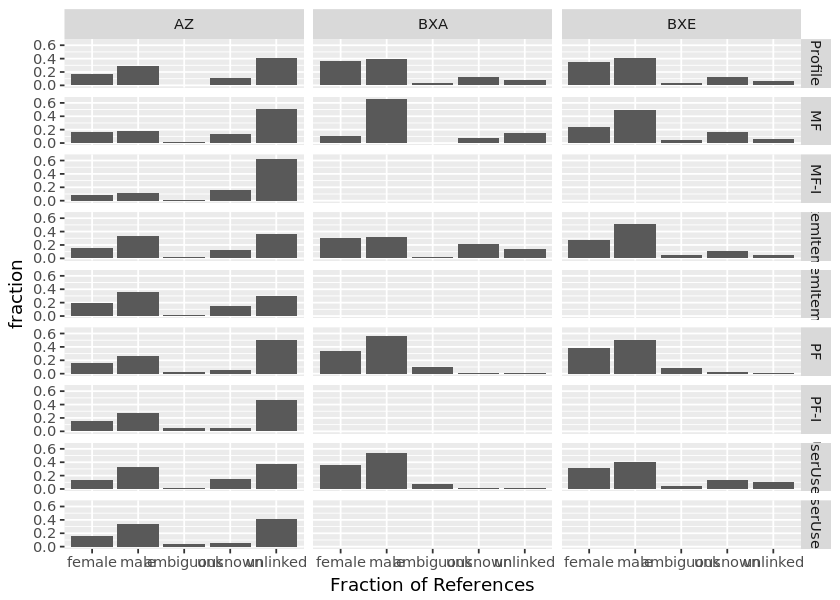

In [31]:
usage_coverage = lists %>%
    select(Set, Algorithm, Book, Gender) %>%
    group_by(Set, Algorithm, Gender) %>%
    summarize(count=n()) %>%
    group_by(Set, Algorithm) %>%
    mutate(fraction=count / sum(count))
ggplot(usage_coverage) +
    aes(x=Gender, y=fraction) +
    geom_bar(stat='identity') +
    facet_grid(Algorithm ~ Set) +
    xlab('Fraction of References')

### How are known-item counts?

First, we want to see the distribution of _profile sizes_:

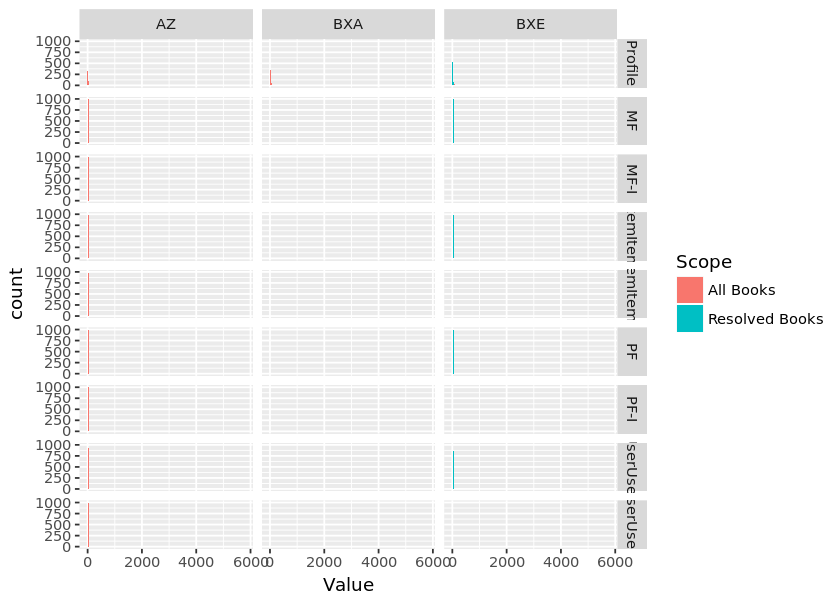

In [32]:
list_stats = list_info %>%
    select(Set, User, Algorithm, Count, Known) %>%
    gather("Scope", "Value", Count, Known) %>%
    mutate(Scope = recode_factor(Scope,
                                 Count="All Books",
                                 Known="Resolved Books",
                                 .ordered=TRUE))
ggplot(list_stats) +
    aes(x=Value, fill=Scope) +
    geom_histogram(binwidth=20, position="dodge") +
    facet_grid(Algorithm ~ Set)

Lots of concentration low, and some outliers. We will filter out large profiles.

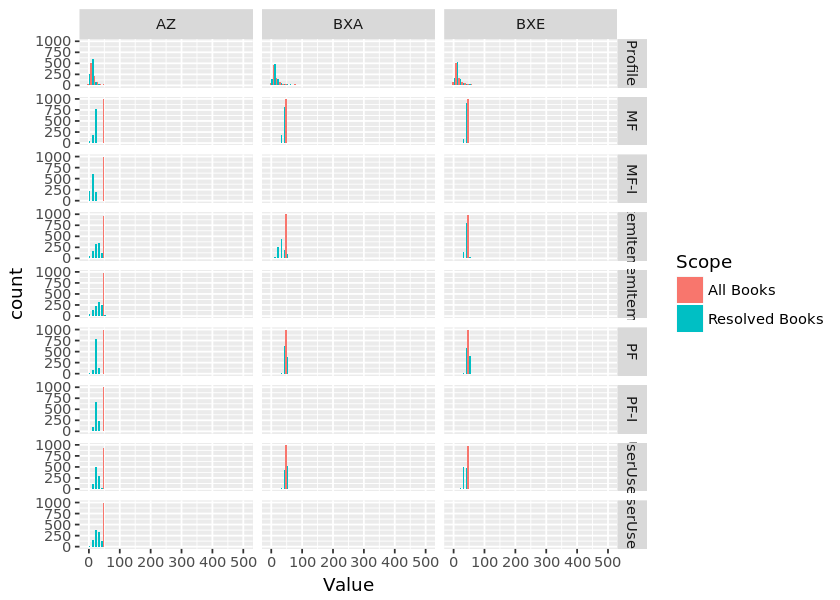

In [33]:
ggplot(filter(list_stats, Value <= 500)) +
    aes(x=Value, fill=Scope) +
    geom_histogram(binwidth=10, position="dodge") +
    facet_grid(Algorithm ~ Set)

Let's look at fraction known:

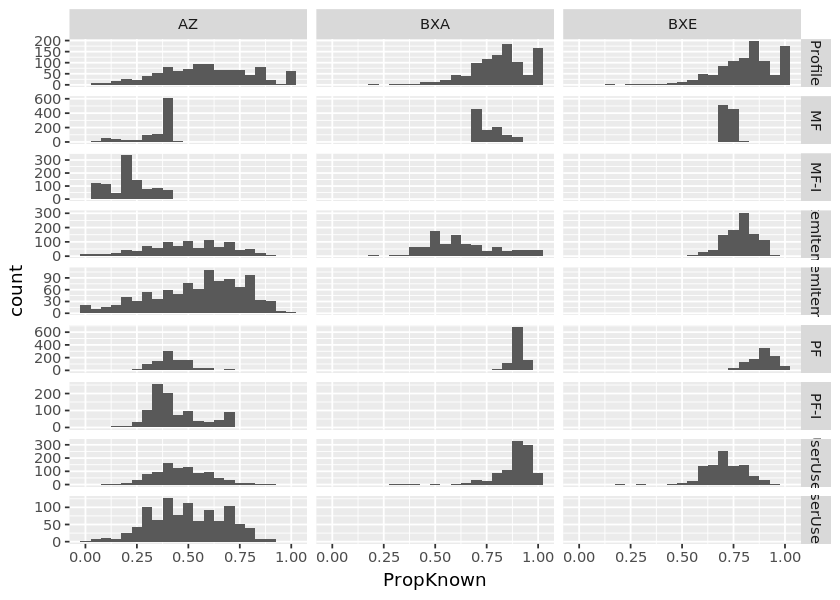

In [34]:
ggplot(list_info) +
    aes(x=PropKnown) +
    geom_histogram(binwidth=0.05) +
    facet_grid(Algorithm ~ Set, scales="free_y")

## How are gender biases distributed?

Warning message:
“Removed 19 rows containing non-finite values (stat_bin).”

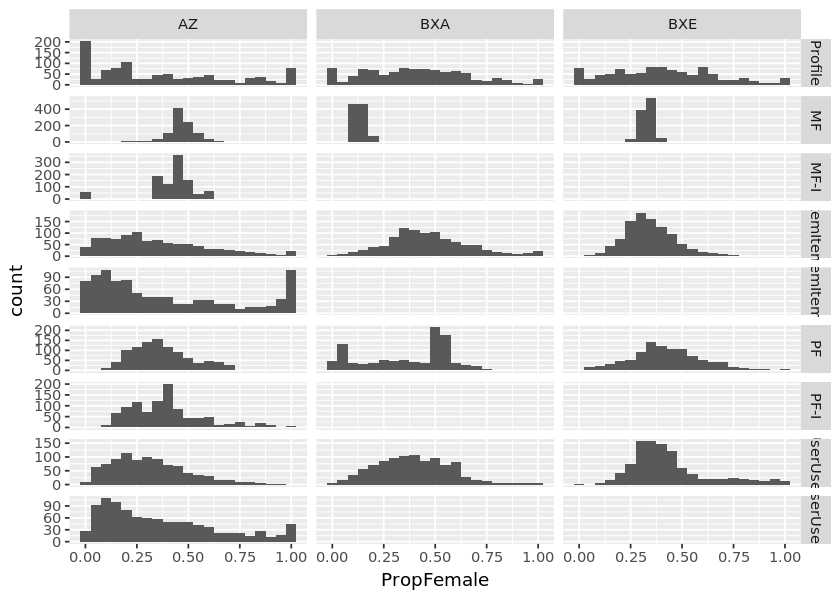

In [35]:
ggplot(list_info) +
    aes(x=PropFemale) +
    geom_histogram(binwidth=0.05) +
    facet_grid(Algorithm ~ Set, scales="free_y")

We need to get some means to annotate the underlying graphs.  We play funny business.

In [36]:
profile_means = list_info %>% filter(Algorithm == 'Profile') %>%
    group_by(Set) %>%
    summarize(PropFemale=mean(PropFemale))
context_means =
    bind_rows(Profile=profile_means,
              Popular=pop_item_stats %>% select(Set, PropFemale),
              .id='Data') %>%
    mutate(Cond=Set, Implicit=Cond == 'AZ', Explicit=TRUE) %>%
    gather(N, V, Implicit, Explicit) %>%
    filter(V) %>%
    transmute(Data, Set, PropFemale,
              Cond=if_else(Set == 'AZ', sprintf('%s (%s)', Set, N), Set))
context_means

Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

Data,Set,PropFemale,Cond
Profile,AZ,0.3664051,AZ (Implicit)
Popular,AZ,0.3750000,AZ (Implicit)
Profile,AZ,0.3664051,AZ (Explicit)
Profile,BXA,0.4102683,BXA
Profile,BXE,0.4076881,BXE
Popular,AZ,0.3750000,AZ (Explicit)
Popular,BXA,0.3777778,BXA
Popular,BXE,0.4130435,BXE


In [37]:
list_plot_info = list_info %>% 
    filter(Algorithm != 'Profile') %>% ungroup() %>%
  mutate(Family=if_else(endsWith(as.character(Algorithm), '-I'),
                        'Implicit', 'Explicit')) %>%
  mutate(Algorithm=ordered(gsub('-I$', '', as.character(Algorithm)),
                           levels=c("UserUser", "ItemItem", "MF", "PF")),
         Cond=if_else(Set == 'AZ', 
                      sprintf('%s (%s)', Set, Family),
                      as.character(Set)))

In [38]:
list_plot_info %>% pull(PropFemale) %>% sd(na.rm=TRUE)

[1] 0.2013708

Build a table of list means:

In [120]:
list_means = list_plot_info %>%
    group_by(Cond, Algorithm) %>%
    summarize(PF=mean(PropFemale, na.rm=TRUE),
              PF.sd=sd(PropFemale, na.rm=TRUE))
list_means %>% select(-PF.sd) %>% spread(Cond, PF) %>%
    select(Algorithm, BXA, BXE, `AZ (Explicit)`, `AZ (Implicit)`)

Algorithm,BXA,BXE,AZ (Explicit),AZ (Implicit)
UserUser,0.3987529,0.4353859,0.3153196,0.3674591
ItemItem,0.4647493,0.3483505,0.3507342,0.3892534
MF,0.1344567,0.3344355,0.4681338,0.4184238
PF,0.3722618,0.4289380,0.3737451,0.3937212


And SDs:

In [121]:
list_means %>% select(-PF) %>% spread(Cond, PF.sd)  %>%
    select(Algorithm, BXA, BXE, `AZ (Explicit)`, `AZ (Implicit)`)

Algorithm,BXA,BXE,AZ (Explicit),AZ (Implicit)
UserUser,0.18083738,0.18962816,0.18635887,0.2782293
ItemItem,0.19986036,0.12430700,0.24491798,0.3359001
MF,0.02665131,0.03862941,0.07887789,0.1242496
PF,0.20790139,0.17652234,0.14418503,0.1774115


In [41]:
plot_means = 
    bind_rows(crossing(context_means, Algorithm=unique(list_means$Algorithm)),
              mutate(list_means, Data='Algorithm', PropFemale=PF))

Warning message:
“Removed 19 rows containing non-finite values (stat_bin).”Warning message:
“Removed 19 rows containing non-finite values (stat_bin).”Warning message:
“Removed 19 rows containing non-finite values (stat_bin).”

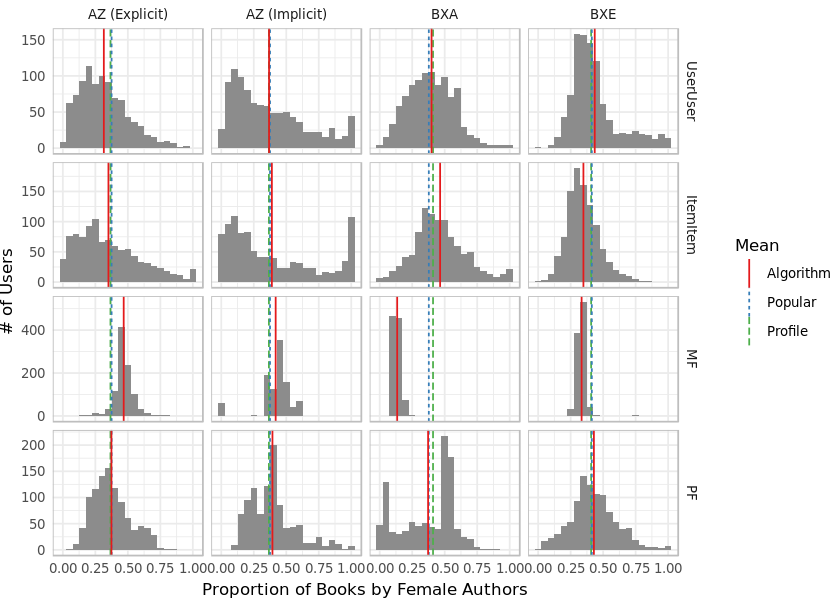

In [12]:
drawplot(file='build/figures/rec-proportions', width=10, height=2.85, {
    ggplot(list_plot_info) +
        aes(x=PropFemale) +
        geom_histogram(binwidth=0.05, fill='grey55') +
        geom_vline(data=rename(plot_means, Mean=Data),
                   mapping=aes(xintercept=PropFemale, color=Mean, linetype=Mean)) +
        facet_grid(Algorithm ~ Cond, scales="free_y") +
        xlab("Proportion of Books by Female Authors") +
        ylab("# of Users") +
        scale_colour_brewer(palette="Set1") +
        theme_paper()
})

Warning message:
“Removed 19 rows containing non-finite values (stat_density).”

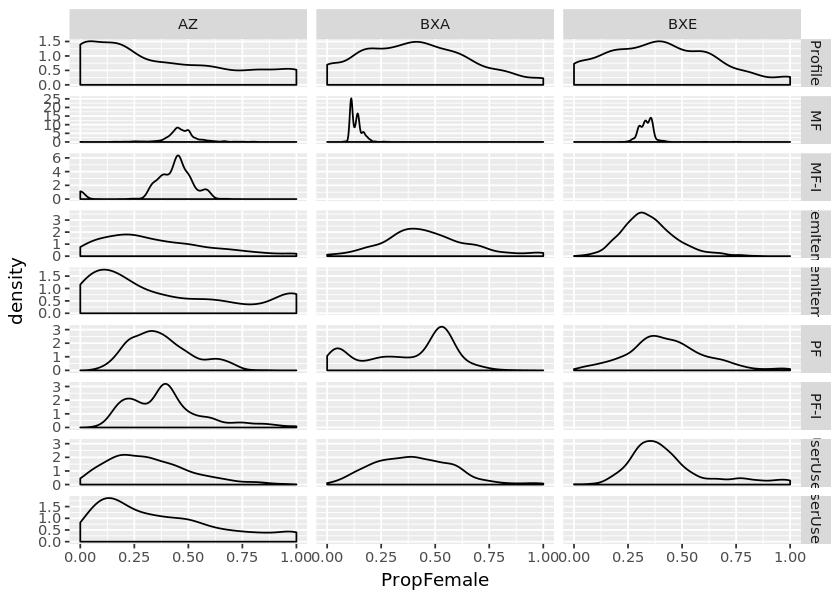

In [44]:
ggplot(list_info) +
    aes(x=PropFemale) +
    geom_density() +
    facet_grid(Algorithm ~ Set, scales="free_y")

## Bayesian Modeling

In [45]:
algorithms = levels(list_info$Algorithm)
algorithms = algorithms[2:length(algorithms)]
algorithms

[1] "MF"         "MF-I"       "ItemItem"   "ItemItem-I" "PF"        
[6] "PF-I"       "UserUser"   "UserUser-I"

### Definition and Priors

See the PDF for the model definition.

### Compile and Load

Load the model:

In [46]:
full_model = stan_model(file="models/full.stan")

In [47]:
fit_model = function(users, lists, model=full_model, chains=4, iter=5000, ...) {
    algos = levels(lists$Algorithm)
    sampling(full_model,
             data=list(A=length(algos), J=nrow(users), NL=nrow(lists),
                       n=users$Known,
                       y=users$NFemale,
                       ru=lists$UNum,
                       ra=as.integer(lists$Algorithm),
                       rn=lists$Known,
                       ry=lists$NFemale),
             chains=chains, iter=iter, ...)
}

### Implicit feedback

In [48]:
bx_implicit_users = list_info %>%
    filter(Set == 'BXA', Algorithm == 'Profile') %>%
    select(User, Known, NFemale) %>%
    arrange(User) %>%
    mutate(UNum = 1:n())
print(bx_implicit_users)

# A tibble: 1,000 x 4
    User Known NFemale  UNum
   <int> <int>   <int> <int>
 1   272     5       2     1
 2   853     5       0     2
 3  1184    17      10     3
 4  1248    21       6     4
 5  1558     6       2     5
 6  2110   124      53     6
 7  2134     9       4     7
 8  2179    44      12     8
 9  2197    10      10     9
10  2375     6       2    10
# ... with 990 more rows


In [49]:
bx_implicit_lists = list_info %>%
    filter(Set == 'BXA', Algorithm != "Profile") %>%
    select(User, Algorithm, Known, NFemale) %>%
    mutate(Algorithm = ordered(as.character(Algorithm))) %>%
    inner_join(select(bx_implicit_users, User, UNum))
print(bx_implicit_lists)

Joining, by = "User"


# A tibble: 4,000 x 5
    User Algorithm Known NFemale  UNum
   <int> <ord>     <int>   <int> <int>
 1   272 MF           35       5     1
 2   272 ItemItem     22      13     1
 3   272 PF           45      23     1
 4   272 UserUser     43      16     1
 5   853 MF           36       4     2
 6   853 ItemItem     30       9     2
 7   853 PF           42      19     2
 8   853 UserUser     46       8     2
 9  1184 MF           38       5     3
10  1184 ItemItem     43      25     3
# ... with 3,990 more rows


And fit it:

In [50]:
bx_implicit_fit = fit_model(bx_implicit_users, bx_implicit_lists)

In [51]:
levels(bx_implicit_lists$Algorithm)

[1] "ItemItem" "MF"       "PF"       "UserUser"

In [52]:
print(bx_implicit_fit, pars=c("mu", "sigma", "nMean", "nDisp", "recB", "recS", "recV"))

Inference for Stan model: full.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

         mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
mu      -0.44    0.00 0.04 -0.51 -0.46 -0.44 -0.41 -0.36 10000    1
sigma    0.99    0.00 0.03  0.92  0.96  0.98  1.01  1.05  2599    1
nMean   35.32    0.02 1.97 31.73 33.94 35.26 36.61 39.43 10000    1
nDisp    0.32    0.00 0.01  0.30  0.31  0.32  0.33  0.35 10000    1
recB[1]  0.18    0.00 0.03  0.12  0.16  0.18  0.20  0.24 10000    1
recB[2] -1.72    0.00 0.01 -1.73 -1.72 -1.72 -1.71 -1.71 10000    1
recB[3] -0.47    0.00 0.04 -0.54 -0.49 -0.47 -0.44 -0.40 10000    1
recB[4] -0.15    0.00 0.02 -0.20 -0.17 -0.15 -0.13 -0.10  5196    1
recS[1]  0.66    0.00 0.03  0.60  0.64  0.66  0.68  0.72  3464    1
recS[2]  0.01    0.00 0.01  0.00  0.01  0.01  0.02  0.03 10000    1
recS[3]  0.54    0.00 0.04  0.46  0.52  0.54  0.57  0.62  4402    1
recS[4]  0.66    0.00 0.03  0.60 

In [53]:
bxi_sims = rstan::extract(bx_implicit_fit, permuted=TRUE)
names(bxi_sims)

[1] "nMean"   "nDisp"   "mu"      "sigma"   "nTheta"  "recB"    "recS"   
 [8] "recV"    "theta"   "rbias"   "noiseR"  "nThetaP" "thetaP"  "nP"     
[15] "yP"      "biasP"   "noiseP"  "thetaRP" "lp__"

We want to do some model checking. Let's make a frame of estimates of recommender parameters.

In [57]:
bxi_rec_params = data_frame(Algorithm=bx_implicit_lists$Algorithm,
                            bias = colMeans(bxi_sims$rbias),
                            resid= colMeans(bxi_sims$noiseR))
bxi_rec_params

Algorithm,bias,resid
MF,-1.72141486,0.07918713
ItemItem,0.01253242,0.32393982
PF,-0.60457175,0.64713136
UserUser,-0.31714473,-0.18184644
MF,-1.73815638,-0.14891327
ItemItem,-0.81353877,0.02508141
PF,-1.28165854,1.09933698
UserUser,-1.13564506,-0.33069201
MF,-1.71413936,-0.02046170
ItemItem,0.37282361,-0.05916605


Test residuals for normality:

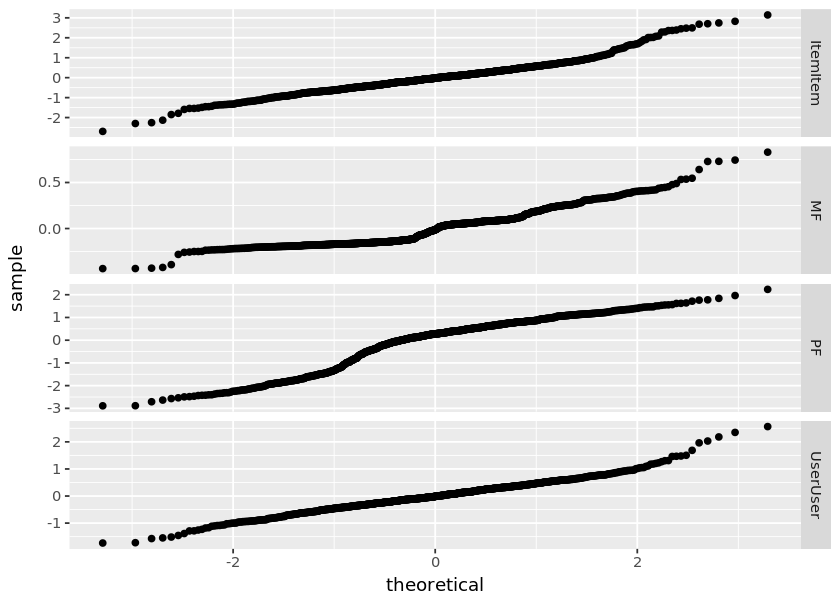

In [58]:
ggplot(bxi_rec_params) +
    aes(sample=resid) +
    geom_qq() +
    facet_grid(Algorithm ~ ., scales="free")

Test for heteroskedasticity:

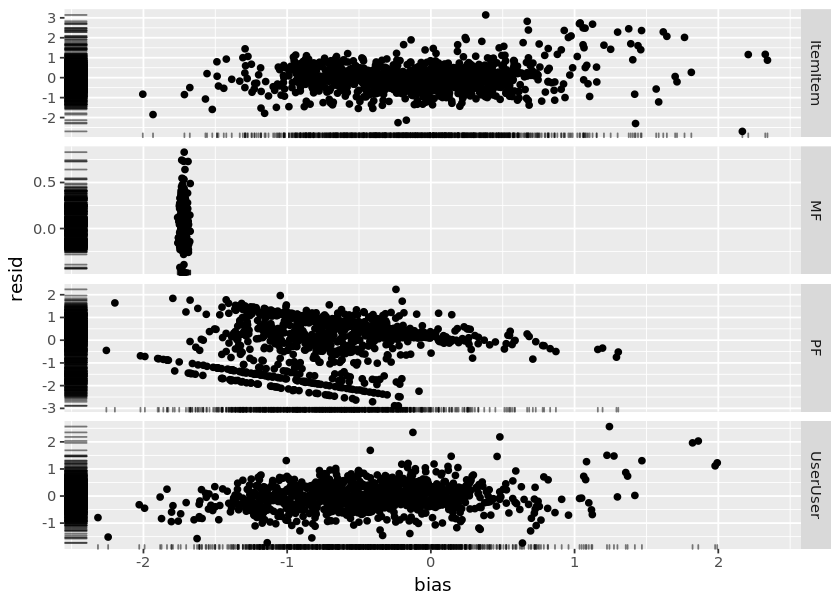

In [59]:
ggplot(bxi_rec_params) +
    aes(x=bias, y=resid) +
    geom_point() + geom_rug(alpha=0.5) +
    facet_grid(Algorithm ~ ., scales="free")

PF is kinda sketchy, but the others are good for the bulk of their mass.

Now, let's try to integrate things into a coherent diagram!

In [60]:
colnames(bxi_sims$thetaRP) = levels(bx_implicit_lists$Algorithm)

In [61]:
bxi_preds =
    bind_cols(data_frame(Profile=bxi_sims$thetaP),
              as_data_frame(bxi_sims$thetaRP)) %>%
    gather(List, Bias)
bxi_intervals = bxi_preds %>%
    group_by(List) %>%
    summarize(Low=quantile(Bias, 0.025),
              High=quantile(Bias, 0.975))
bxi_biases =
    bind_rows(Observed=list_info %>% 
                  filter(Set=='BXA', !is.na(PropFemale)) %>%
                  transmute(List=Algorithm,
                            Bias=(NFemale + 1) / (Known + 2)),
              Predicted=bxi_preds,
              .id="Method") %>%
    group_by(Method, List) %>%
    summarize(Dens=list(density_frame(Bias, from=0, to=1))) %>%
    unnest(Dens) %>%
    inner_join(bxi_intervals)

Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Joining, by = "List"


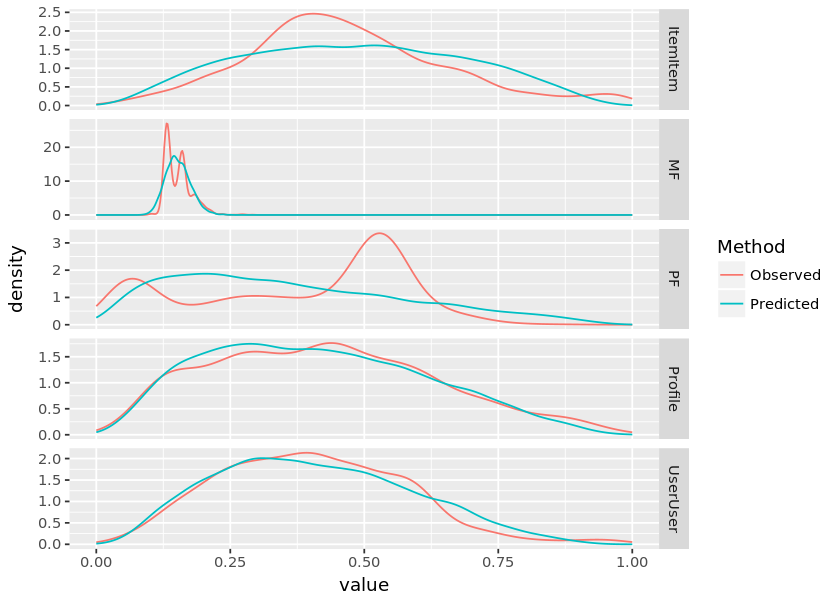

In [62]:
ggplot(bxi_biases) +
    aes(x=value, y=density, color=Method) +
    geom_line() +
    facet_grid(List ~ ., scales="free_y")

In [63]:
bxi_lines = data_frame(Algorithm=levels(bx_implicit_lists$Algorithm), 
                       Intercept=colMeans(bxi_sims$recB),
                       Slope=colMeans(bxi_sims$recS))
bxi_lines

Algorithm,Intercept,Slope
ItemItem,0.1793086,0.66181221
MF,-1.7180350,0.01335165
PF,-0.4683066,0.54240410
UserUser,-0.1513934,0.65614857


In [64]:
bxi_curves = crossing(x=seq(0,1,0.01), bxi_lines) %>%
    mutate(y=logistic(Intercept + Slope * logit(x)))
bxi_curves

x,Algorithm,Intercept,Slope,y
0.00,ItemItem,0.1793086,0.66181221,0.00000000
0.00,MF,-1.7180350,0.01335165,0.00000000
0.00,PF,-0.4683066,0.54240410,0.00000000
0.00,UserUser,-0.1513934,0.65614857,0.00000000
0.01,ItemItem,0.1793086,0.66181221,0.05407467
0.01,MF,-1.7180350,0.01335165,0.14437879
0.01,PF,-0.4683066,0.54240410,0.04923237
0.01,UserUser,-0.1513934,0.65614857,0.04044701
0.02,ItemItem,0.1793086,0.66181221,0.08345179
0.02,MF,-1.7180350,0.01335165,0.14554267


In [65]:
bxi_io = list_info %>% filter(Set == 'BXA') %>%
    transmute(User, Algorithm, Bias=(NFemale + 1) / (Known + 2)) %>%
    spread(Algorithm, Bias) %>%
    gather(Algorithm, Bias, -User, -Profile)

Saving incorrect line code:

    geom_abline(data=bxi_lines, mapping=aes(slope=Slope, intercept=Intercept),
                color="red") +

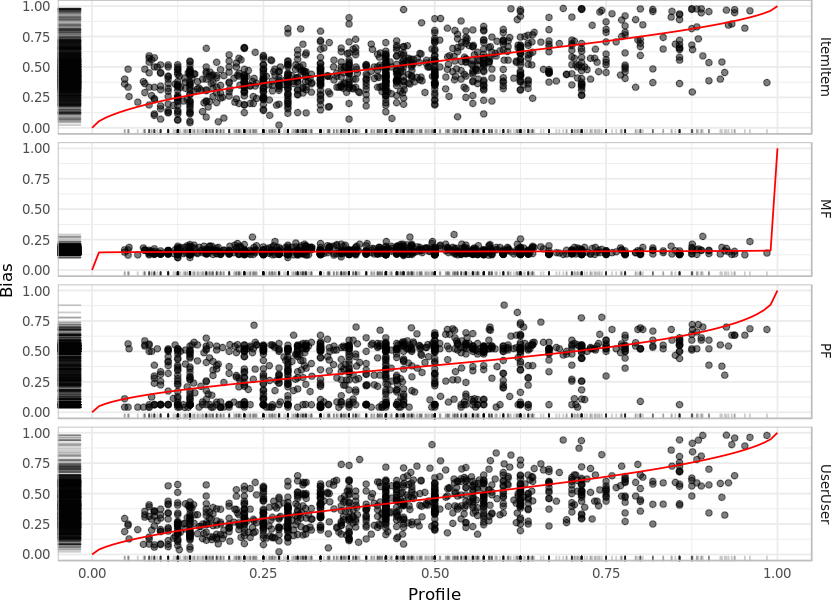

In [66]:
ggplot(bxi_io) +
    aes(x=Profile, y=Bias) +
    geom_point(alpha=0.5) +
    geom_rug(alpha=0.2) +
    geom_line(data=bxi_curves, mapping=aes(x,y), color="red") +
    facet_grid(Algorithm ~ .) +
    theme_paper()

### Explicit Feedback

In [67]:
bx_explicit_users = list_info %>%
    filter(Set == 'BXE', Algorithm == 'Profile') %>%
    select(User, Known, NFemale) %>%
    arrange(User) %>%
    mutate(UNum = 1:n())
print(bx_explicit_users)

# A tibble: 1,000 x 4
    User Known NFemale  UNum
   <int> <int>   <int> <int>
 1   638    52      16     1
 2   901    10       0     2
 3  1075    10       3     3
 4  1248    21       6     4
 5  1435    34       8     5
 6  1688     5       4     6
 7  2358    20      12     7
 8  3282    21      17     8
 9  3331    11       5     9
10  3757    88      16    10
# ... with 990 more rows


In [68]:
bx_explicit_lists = list_info %>%
    filter(Set == 'BXE', Algorithm != "Profile") %>%
    select(User, Algorithm, Known, NFemale) %>%
    mutate(Algorithm = ordered(as.character(Algorithm))) %>%
    inner_join(select(bx_explicit_users, User, UNum))
print(bx_explicit_lists)

Joining, by = "User"


# A tibble: 3,985 x 5
    User Algorithm Known NFemale  UNum
   <int> <ord>     <int>   <int> <int>
 1   638 MF           37      11     1
 2   638 ItemItem     40      13     1
 3   638 PF           47      34     1
 4   638 UserUser     34      27     1
 5   901 MF           36      13     2
 6   901 ItemItem     40      13     2
 7   901 PF           41      14     2
 8   901 UserUser     29       9     2
 9  1075 MF           36      13     3
10  1075 ItemItem     39      16     3
# ... with 3,975 more rows


In [69]:
bx_explicit_fit = fit_model(bx_explicit_users, bx_explicit_lists)

In [70]:
levels(bx_explicit_lists$Algorithm)

[1] "ItemItem" "MF"       "PF"       "UserUser"

In [71]:
print(bx_explicit_fit, pars=c("mu", "sigma", "nMean", "nDisp", "recB", "recS", "recV"))

Inference for Stan model: full.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

         mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
mu      -0.45    0.00 0.04 -0.53 -0.48 -0.45 -0.42 -0.37 10000    1
sigma    1.12    0.00 0.04  1.04  1.09  1.12  1.14  1.20  3320    1
nMean   20.76    0.01 1.10 18.72 20.00 20.73 21.48 22.97 10000    1
nDisp    0.36    0.00 0.02  0.34  0.35  0.36  0.38  0.40 10000    1
recB[1] -0.57    0.00 0.02 -0.61 -0.59 -0.57 -0.56 -0.54 10000    1
recB[2] -0.65    0.00 0.01 -0.66 -0.66 -0.65 -0.65 -0.64 10000    1
recB[3] -0.17    0.00 0.03 -0.22 -0.19 -0.17 -0.15 -0.11 10000    1
recB[4] -0.14    0.00 0.03 -0.20 -0.16 -0.14 -0.12 -0.08 10000    1
recS[1]  0.13    0.00 0.02  0.09  0.12  0.13  0.14  0.16  6842    1
recS[2]  0.00    0.00 0.00 -0.01  0.00  0.00  0.01  0.01 10000    1
recS[3]  0.30    0.00 0.03  0.25  0.28  0.30  0.32  0.35  5189    1
recS[4]  0.16    0.00 0.03  0.10 

In [72]:
bxe_sims = rstan::extract(bx_explicit_fit, permuted=TRUE)
names(bxe_sims)

[1] "nMean"   "nDisp"   "mu"      "sigma"   "nTheta"  "recB"    "recS"   
 [8] "recV"    "theta"   "rbias"   "noiseR"  "nThetaP" "thetaP"  "nP"     
[15] "yP"      "biasP"   "noiseP"  "thetaRP" "lp__"

We want to do some model checking. Let's make a frame of estimates of recommender parameters.

In [76]:
bxe_rec_params = data_frame(Algorithm=bx_explicit_lists$Algorithm,
                            bias = colMeans(bxe_sims$rbias),
                            resid=colMeans(bxe_sims$noiseR))
bxe_rec_params

Algorithm,bias,resid
MF,-0.6532789,-0.15765130
ItemItem,-0.6672224,-0.02592482
PF,-0.3823811,1.29867180
UserUser,-0.2563173,1.50908029
MF,-0.6556246,0.11662806
ItemItem,-0.8348024,0.14165520
PF,-0.7696893,0.14553503
UserUser,-0.4674702,-0.27446717
MF,-0.6526361,0.11363960
ItemItem,-0.6304992,0.28565867


Test residuals for normality:

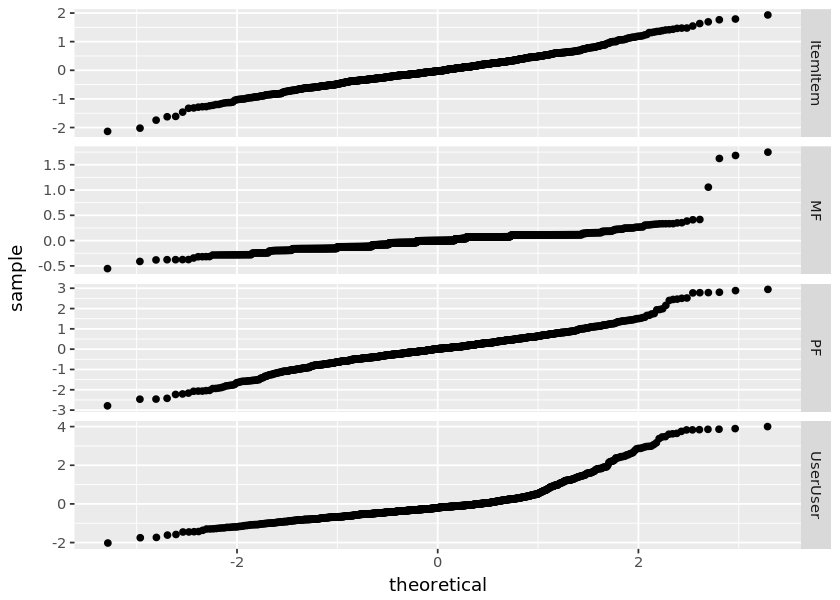

In [77]:
ggplot(bxe_rec_params) +
    aes(sample=resid) +
    geom_qq() +
    facet_grid(Algorithm ~ ., scales="free")

Test for heteroskedasticity:

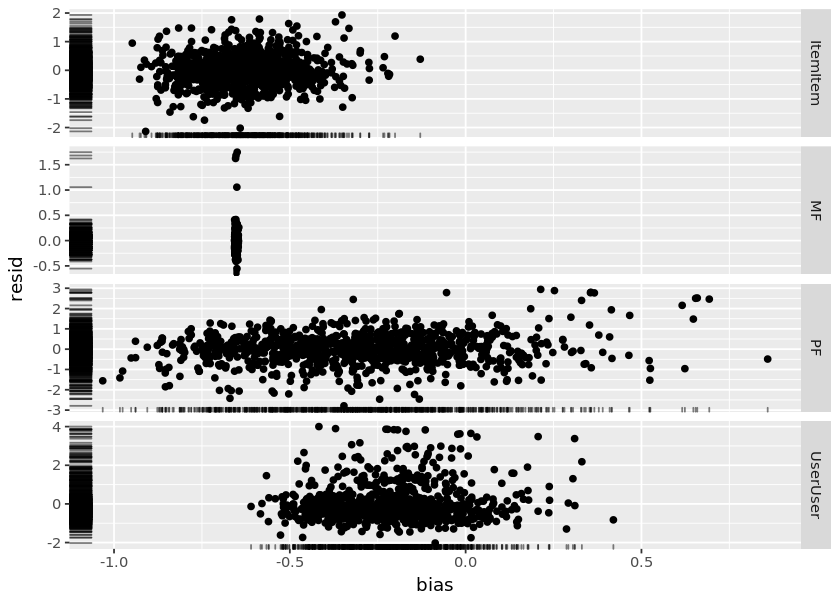

In [78]:
ggplot(bxe_rec_params) +
    aes(x=bias, y=resid) +
    geom_point() + geom_rug(alpha=0.5) +
    facet_grid(Algorithm ~ ., scales="free")

Now, let's try to integrate things into a coherent diagram!

In [79]:
colnames(bxe_sims$thetaRP) = levels(bx_explicit_lists$Algorithm)

In [80]:
bxe_preds =
    bind_cols(data_frame(Profile=bxe_sims$thetaP),
              as_data_frame(bxe_sims$thetaRP)) %>%
    gather(List, Bias)
bxe_intervals = bxe_preds %>%
    group_by(List) %>%
    summarize(Low=quantile(Bias, 0.025),
              High=quantile(Bias, 0.975))
bxe_biases =
    bind_rows(Observed=list_info %>% 
                  filter(Set=='BXE', !is.na(PropFemale)) %>%
                  transmute(List=Algorithm,
                            Bias=(NFemale + 1) / (Known + 2)),
              Predicted=bxe_preds,
              .id="Method") %>%
    group_by(Method, List) %>%
    summarize(Dens=list(density_frame(Bias, from=0, to=1))) %>%
    unnest(Dens) %>%
    inner_join(bxi_intervals)

Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Joining, by = "List"


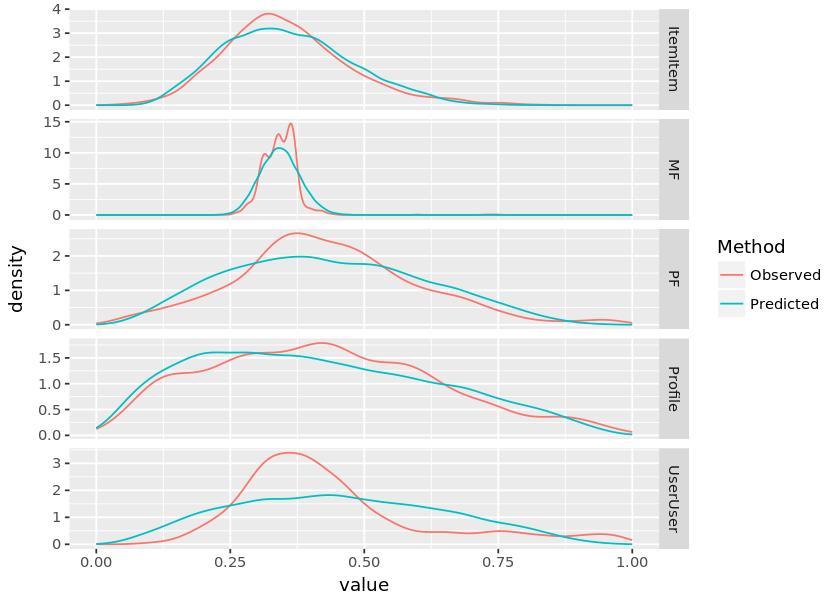

In [81]:
ggplot(bxe_biases) +
    aes(x=value, y=density, color=Method) +
    geom_line() +
    facet_grid(List ~ ., scales="free_y")

In [82]:
bxe_lines = data_frame(Algorithm=levels(bx_explicit_lists$Algorithm), 
                       Intercept=colMeans(bxe_sims$recB),
                       Slope=colMeans(bxe_sims$recS))
bxe_lines

Algorithm,Intercept,Slope
ItemItem,-0.5734886,0.129028406
MF,-0.6518374,0.001933878
PF,-0.1664121,0.297810820
UserUser,-0.1386331,0.162317510


In [83]:
bxe_curves = crossing(x=seq(0,1,0.01), bxe_lines) %>%
    mutate(y=logistic(Intercept + Slope * logit(x)))
bxe_curves

x,Algorithm,Intercept,Slope,y
0.00,ItemItem,-0.5734886,0.129028406,0.0000000
0.00,MF,-0.6518374,0.001933878,0.0000000
0.00,PF,-0.1664121,0.297810820,0.0000000
0.00,UserUser,-0.1386331,0.162317510,0.0000000
0.01,ItemItem,-0.5734886,0.129028406,0.2375082
0.01,MF,-0.6518374,0.001933878,0.3405770
0.01,PF,-0.1664121,0.297810820,0.1772796
0.01,UserUser,-0.1386331,0.162317510,0.2922458
0.02,ItemItem,-0.5734886,0.129028406,0.2543312
0.02,MF,-0.6518374,0.001933878,0.3408826


In [84]:
bxe_io = list_info %>% filter(Set == 'BXE') %>%
    transmute(User, Algorithm, Bias=(NFemale + 1) / (Known + 2)) %>%
    spread(Algorithm, Bias) %>%
    gather(Algorithm, Bias, -User, -Profile)

Saving incorrect line code:

    geom_abline(data=bxi_lines, mapping=aes(slope=Slope, intercept=Intercept),
                color="red") +

Warning message:
“Removed 15 rows containing missing values (geom_point).”

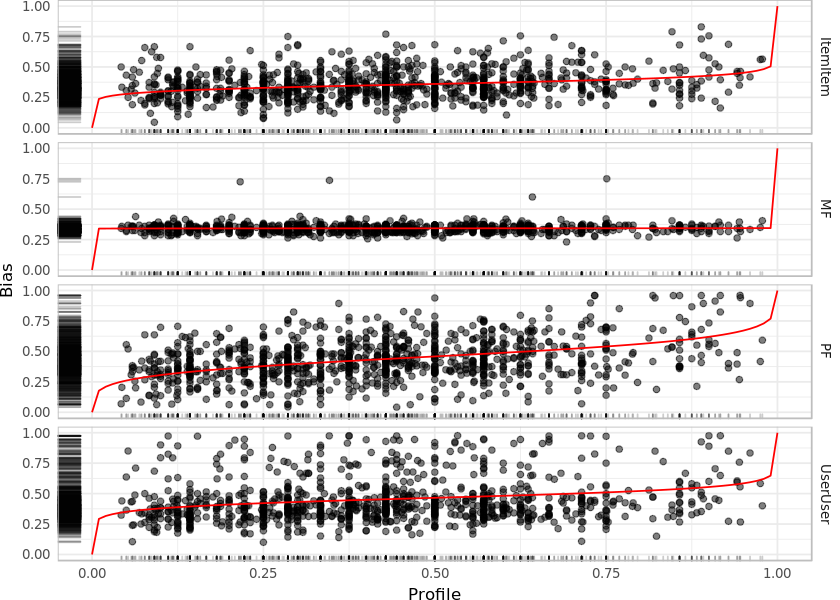

In [85]:
ggplot(bxe_io) +
    aes(x=Profile, y=Bias) +
    geom_point(alpha=0.5) +
    geom_rug(alpha=0.2) +
    geom_line(data=bxe_curves, mapping=aes(x,y), color="red") +
    facet_grid(Algorithm ~ .) +
    theme_paper()

## Amazon Data

In [86]:
az_users = list_info %>%
    filter(Set == 'AZ', Algorithm == 'Profile') %>%
    select(User, Known, NFemale) %>%
    arrange(User) %>%
    mutate(UNum = 1:n())
print(az_users)

# A tibble: 1,000 x 4
    User Known NFemale  UNum
   <int> <int>   <int> <int>
 1  1306     5       0     1
 2  8296     7       3     2
 3  9047    12       0     3
 4 21468     6       5     4
 5 29992    14       1     5
 6 47631     5       3     6
 7 62885    16       1     7
 8 66610    11       0     8
 9 73428    12       6     9
10 76016     5       2    10
# ... with 990 more rows


In [87]:
az_explicit_lists = list_info %>%
    filter(Set == 'AZ', Algorithm != 'Profile') %>%
    select(User, Algorithm, Known, NFemale) %>%
    mutate(Algorithm = ordered(as.character(Algorithm))) %>%
    inner_join(select(az_users, User, UNum))
print(az_explicit_lists)

Joining, by = "User"


# A tibble: 7,937 x 5
    User Algorithm  Known NFemale  UNum
   <int> <ord>      <int>   <int> <int>
 1  1306 MF            20      10     1
 2  1306 MF-I           3       1     1
 3  1306 ItemItem      19       4     1
 4  1306 ItemItem-I    22       5     1
 5  1306 PF            23       6     1
 6  1306 PF-I          18       7     1
 7  1306 UserUser-I    24       6     1
 8  8296 MF            20       9     2
 9  8296 MF-I          11       5     2
10  8296 ItemItem      13      10     2
# ... with 7,927 more rows


In [88]:
az_explicit_fit = fit_model(az_users, az_explicit_lists)

In [89]:
print(az_explicit_fit, pars=c("mu", "sigma", "nMean", "nDisp", "recB", "recS", "recV"))

Inference for Stan model: full.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

         mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
mu      -0.73    0.00 0.06 -0.85 -0.77 -0.73 -0.68 -0.60 10000    1
sigma    1.75    0.00 0.06  1.64  1.71  1.75  1.79  1.87  1698    1
nMean    9.43    0.01 0.52  8.48  9.07  9.41  9.77 10.50 10000    1
nDisp    0.35    0.00 0.02  0.32  0.33  0.34  0.36  0.38 10000    1
recB[1] -0.38    0.00 0.03 -0.44 -0.40 -0.38 -0.36 -0.32  5102    1
recB[2]  0.09    0.00 0.04  0.02  0.07  0.09  0.12  0.17  3224    1
recB[3] -0.12    0.00 0.01 -0.14 -0.12 -0.12 -0.11 -0.10 10000    1
recB[4] -0.24    0.00 0.01 -0.27 -0.25 -0.24 -0.24 -0.22 10000    1
recB[5] -0.40    0.00 0.02 -0.44 -0.42 -0.40 -0.39 -0.37  7489    1
recB[6] -0.22    0.00 0.02 -0.26 -0.24 -0.22 -0.21 -0.18  5149    1
recB[7] -0.58    0.00 0.03 -0.63 -0.60 -0.58 -0.56 -0.53  5640    1
recB[8] -0.13    0.00 0.03 -0.19 

In [90]:
aze_sims = rstan::extract(az_explicit_fit, permuted=TRUE)
names(aze_sims)

[1] "nMean"   "nDisp"   "mu"      "sigma"   "nTheta"  "recB"    "recS"   
 [8] "recV"    "theta"   "rbias"   "noiseR"  "nThetaP" "thetaP"  "nP"     
[15] "yP"      "biasP"   "noiseP"  "thetaRP" "lp__"

We want to do some model checking. Let's make a frame of estimates of recommender parameters.

In [91]:
aze_rec_params = data_frame(Algorithm=az_explicit_lists$Algorithm,
                            bias = colMeans(aze_sims$rbias),
                            resid=colMeans(aze_sims$noiseR))
aze_rec_params

Algorithm,bias,resid
MF,-0.1263773,0.12637730
MF-I,-0.2623443,-0.14312082
ItemItem,-1.0851363,-0.07801446
ItemItem-I,-1.2961995,0.19758719
PF,-0.6295604,-0.31490117
PF-I,-0.6870608,0.28159569
UserUser-I,-1.2357303,0.23720149
MF,-0.1188772,-0.06344436
MF-I,-0.2470947,0.09294401
ItemItem,-0.4989326,1.51053352


Test residuals for normality:

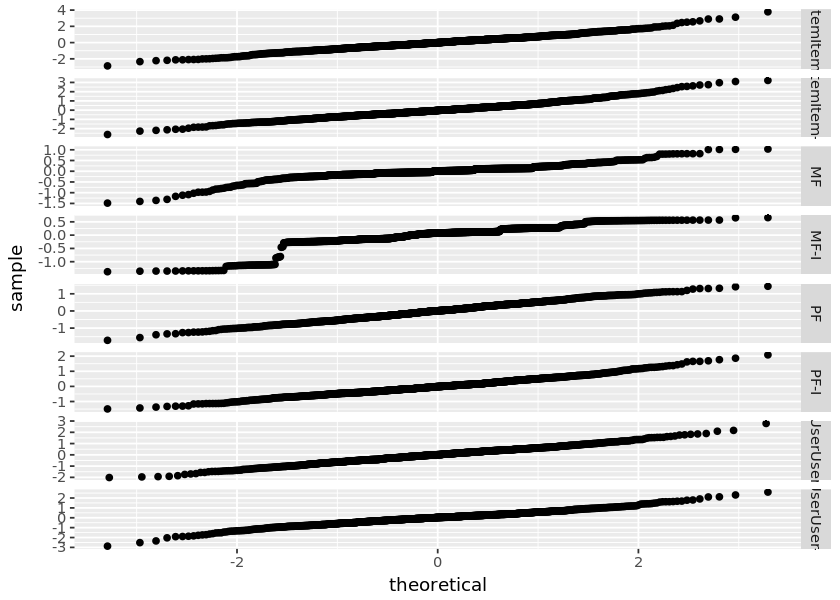

In [95]:
ggplot(aze_rec_params) +
    aes(sample=resid) +
    geom_qq() +
    facet_grid(Algorithm ~ ., scales="free")

Test for heteroskedasticity:

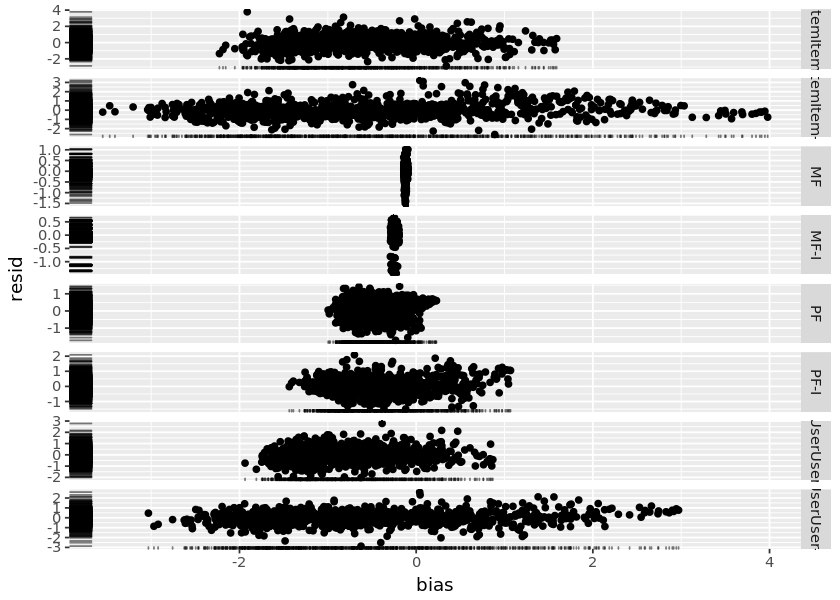

In [96]:
ggplot(aze_rec_params) +
    aes(x=bias, y=resid) +
    geom_point() + geom_rug(alpha=0.5) +
    facet_grid(Algorithm ~ ., scales="free")

Now, let's try to integrate things into a coherent diagram!

In [97]:
colnames(aze_sims$thetaRP) = levels(az_explicit_lists$Algorithm)

In [98]:
aze_preds =
    bind_cols(data_frame(Profile=aze_sims$thetaP),
              as_data_frame(aze_sims$thetaRP)) %>%
    gather(List, Bias)
aze_intervals = aze_preds %>%
    group_by(List) %>%
    summarize(Low=quantile(Bias, 0.025),
              High=quantile(Bias, 0.975))
aze_biases =
    bind_rows(Observed=list_info %>% 
                  filter(Set=='AZ', !is.na(PropFemale)) %>%
                  transmute(List=Algorithm,
                            Bias=(NFemale + 1) / (Known + 2)),
              Predicted=aze_preds,
              .id="Method") %>%
    group_by(Method, List) %>%
    summarize(Dens=list(density_frame(Bias, from=0, to=1))) %>%
    unnest(Dens)
head(aze_biases)

Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

Method,List,value,density
Observed,ItemItem,0.000000000,0.3396070
Observed,ItemItem,0.001956947,0.3568676
Observed,ItemItem,0.003913894,0.3745463
Observed,ItemItem,0.005870841,0.3926649
Observed,ItemItem,0.007827789,0.4114200
Observed,ItemItem,0.009784736,0.4305650


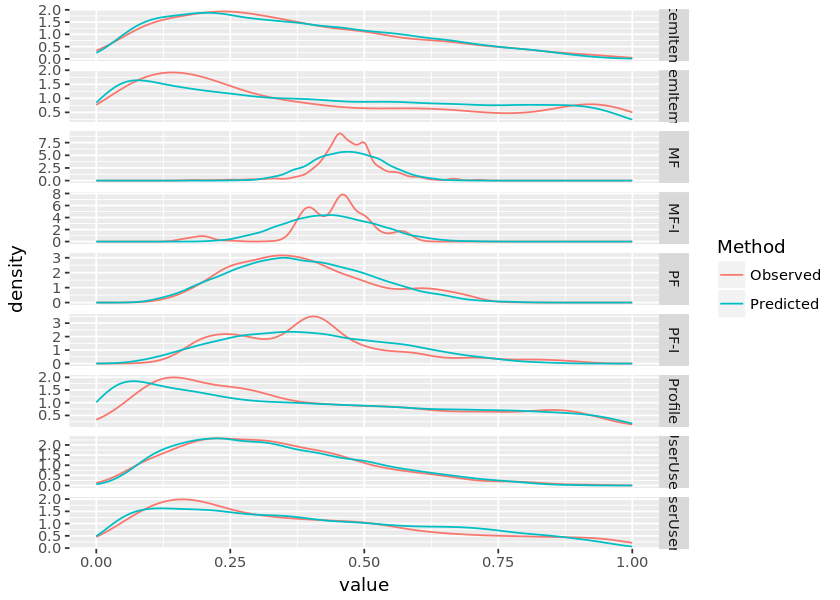

In [99]:
ggplot(aze_biases) +
    aes(x=value, y=density, color=Method) +
    geom_line() +
    facet_grid(List ~ ., scales="free_y")

In [100]:
aze_lines = data_frame(Algorithm=levels(az_explicit_lists$Algorithm),
                       Intercept=colMeans(aze_sims$recB),
                       Slope=colMeans(aze_sims$recS))
aze_lines

Algorithm,Intercept,Slope
ItemItem,-0.37992717,0.437525492
ItemItem-I,0.09423448,0.862858355
MF,-0.11741232,0.005550768
MF-I,-0.24398605,0.011382660
PF,-0.40299882,0.140548499
PF-I,-0.22444355,0.287077529
UserUser,-0.57973099,0.321553932
UserUser-I,-0.12731913,0.687918959


In [101]:
aze_curves = crossing(x=seq(0,1,0.01), aze_lines) %>%
    mutate(y=logistic(Intercept + Slope * logit(x)))
aze_curves

x,Algorithm,Intercept,Slope,y
0.00,ItemItem,-0.37992717,0.437525492,0.00000000
0.00,ItemItem-I,0.09423448,0.862858355,0.00000000
0.00,MF,-0.11741232,0.005550768,0.00000000
0.00,MF-I,-0.24398605,0.011382660,0.00000000
0.00,PF,-0.40299882,0.140548499,0.00000000
0.00,PF-I,-0.22444355,0.287077529,0.00000000
0.00,UserUser,-0.57973099,0.321553932,0.00000000
0.00,UserUser-I,-0.12731913,0.687918959,0.00000000
0.01,ItemItem,-0.37992717,0.437525492,0.08390697
0.01,ItemItem-I,0.09423448,0.862858355,0.02041812


In [102]:
aze_io = list_info %>% filter(Set == 'AZ') %>%
    transmute(User, Algorithm, Bias=(NFemale + 1) / (Known + 2)) %>%
    spread(Algorithm, Bias) %>%
    gather(Algorithm, Bias, -User, -Profile)

Saving incorrect line code:

    geom_abline(data=bxi_lines, mapping=aes(slope=Slope, intercept=Intercept),
                color="red") +

Warning message:
“Removed 63 rows containing missing values (geom_point).”

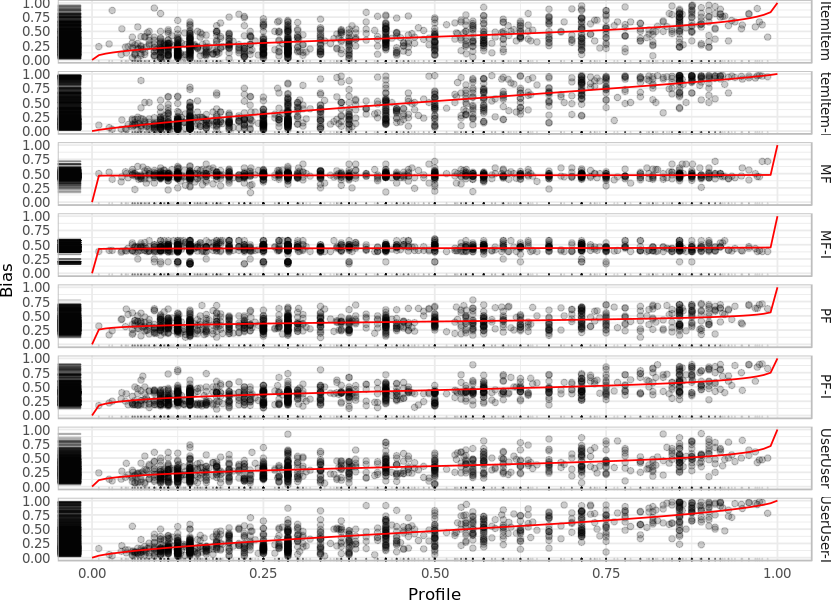

In [74]:
ggplot(aze_io) +
    aes(x=Profile, y=Bias) +
    geom_point(alpha=0.2) +
    geom_rug(alpha=0.15) +
    geom_line(data=aze_curves, mapping=aes(x,y), color="red") +
    facet_grid(Algorithm ~ .) +
    theme_paper()

## Integrate Plots

In [104]:
rec_biases = 
    bind_rows(BXA=bxi_biases, BXE=bxe_biases, AZ=aze_biases, .id='Set') %>%
    filter(List != 'Profile') %>%
    mutate(Family=if_else(endsWith(as.character(List), '-I'),
                          'Implicit', 'Explicit')) %>%
    mutate(List=ordered(gsub('-I$', '', as.character(List)),
                        levels=c("UserUser", "ItemItem", "MF", "PF")),
           Cond=if_else(Set == 'AZ', 
                        sprintf('%s (%s)', Set, Family),
                        as.character(Set)))
head(rec_biases)

Set,Method,List,value,density,Low,High,Family,Cond
BXA,Observed,ItemItem,0.000000000,0.03658643,0.115061,0.8613506,Explicit,BXA
BXA,Observed,ItemItem,0.001956947,0.03926225,0.115061,0.8613506,Explicit,BXA
BXA,Observed,ItemItem,0.003913894,0.04205468,0.115061,0.8613506,Explicit,BXA
BXA,Observed,ItemItem,0.005870841,0.04499076,0.115061,0.8613506,Explicit,BXA
BXA,Observed,ItemItem,0.007827789,0.04807005,0.115061,0.8613506,Explicit,BXA
BXA,Observed,ItemItem,0.009784736,0.05126723,0.115061,0.8613506,Explicit,BXA


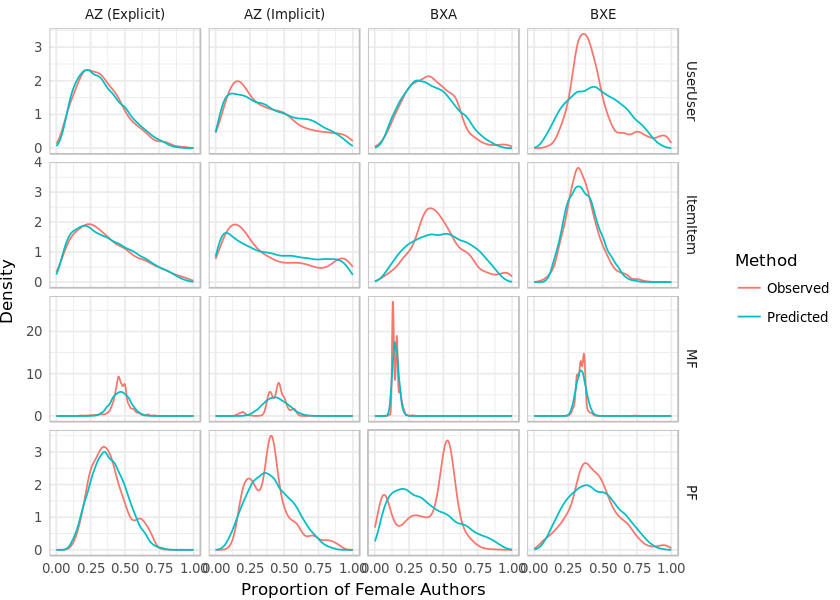

In [105]:
drawplot(file='build/figures/rec-densities', width=10, height=2.5, {
    ggplot(rec_biases) +
        aes(x=value, y=density, color=Method) +
        geom_line() +
        facet_grid(List ~ Cond, scales="free_y") +
        xlab("Proportion of Female Authors") + 
        ylab("Density") +
        theme_paper()
})

Like with author models, we want to integrate histograms into these plots. Yippee!

Warning message:
“Removed 19 rows containing non-finite values (stat_bin).”Warning message:
“Removed 19 rows containing non-finite values (stat_bin).”Warning message:
“Removed 19 rows containing non-finite values (stat_bin).”

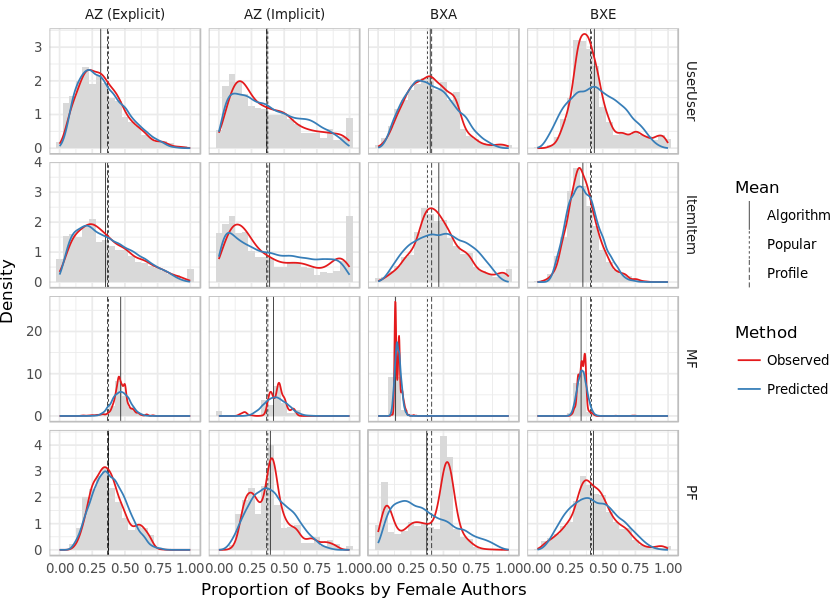

In [68]:
drawplot(file='build/figures/rec-integrated', width=10, height=2.85, {
    ggplot(list_plot_info) +
        aes(x=PropFemale, y=..density..) +
        geom_histogram(binwidth=0.05, fill='grey85') +
        geom_vline(data=rename(plot_means, Mean=Data),
                   mapping=aes(xintercept=PropFemale, linetype=Mean),
                   size=0.2) +
        geom_line(data=rec_biases %>% rename(Algorithm=List),
                  mapping=aes(x=value, y=density, color=Method),
                  size=0.5) +
        facet_grid(Algorithm ~ Cond, scales="free_y") +
        xlab("Proportion of Books by Female Authors") +
        ylab("Density") +
        scale_colour_brewer(palette="Set1") +
        theme_paper()
})

Now work on integrating scatter plots.

In [106]:
rec_io = 
    bind_rows(BXA=bxi_io, BXE=bxe_io, AZ=aze_io, .id='Set') %>%
    filter(Algorithm != 'Profile') %>%
    mutate(Family=if_else(endsWith(as.character(Algorithm), '-I'),
                          'Implicit', 'Explicit')) %>%
    mutate(Algorithm=ordered(gsub('-I$', '', as.character(Algorithm)),
                        levels=c("UserUser", "ItemItem", "MF", "PF")),
           Cond=if_else(Set == 'AZ', 
                        sprintf('%s (%s)', Set, Family),
                        as.character(Set)))
head(rec_io)

Set,User,Profile,Algorithm,Bias,Family,Cond
BXA,272,0.4285714,MF,0.1621622,Explicit,BXA
BXA,853,0.1428571,MF,0.1315789,Explicit,BXA
BXA,1184,0.5789474,MF,0.1500000,Explicit,BXA
BXA,1248,0.3043478,MF,0.1500000,Explicit,BXA
BXA,1558,0.3750000,MF,0.1351351,Explicit,BXA
BXA,2110,0.4285714,MF,0.1956522,Explicit,BXA


In [107]:
rec_curves = 
    bind_rows(BXA=bxi_curves, BXE=bxe_curves, AZ=aze_curves, .id='Set') %>%
    filter(Algorithm != 'Profile') %>%
    mutate(Family=if_else(endsWith(as.character(Algorithm), '-I'),
                          'Implicit', 'Explicit')) %>%
    mutate(Algorithm=ordered(gsub('-I$', '', as.character(Algorithm)),
                        levels=c("UserUser", "ItemItem", "MF", "PF")),
           Cond=if_else(Set == 'AZ', 
                        sprintf('%s (%s)', Set, Family),
                        as.character(Set)))
head(rec_curves)

Set,x,Algorithm,Intercept,Slope,y,Family,Cond
BXA,0.00,ItemItem,0.1793086,0.66181221,0.00000000,Explicit,BXA
BXA,0.00,MF,-1.7180350,0.01335165,0.00000000,Explicit,BXA
BXA,0.00,PF,-0.4683066,0.54240410,0.00000000,Explicit,BXA
BXA,0.00,UserUser,-0.1513934,0.65614857,0.00000000,Explicit,BXA
BXA,0.01,ItemItem,0.1793086,0.66181221,0.05407467,Explicit,BXA
BXA,0.01,MF,-1.7180350,0.01335165,0.14437879,Explicit,BXA


Warning message:
“Removed 78 rows containing missing values (geom_point).”Warning message:
“Removed 78 rows containing missing values (geom_point).”Warning message:
“Removed 78 rows containing missing values (geom_point).”

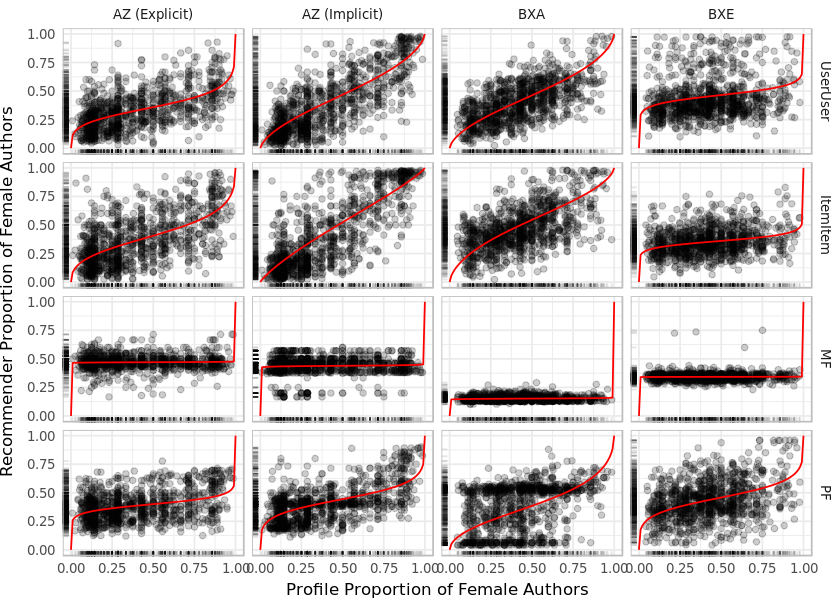

In [75]:
drawplot(file='build/figures/rec-scatter', width=10, height=3.5, {
    ggplot(rec_io) +
        aes(x=Profile, y=Bias) +
        geom_point(alpha=0.2) +
        geom_rug(alpha=0.1) +
        geom_line(data=rec_curves, mapping=aes(x,y), color="red") +
        facet_grid(Algorithm ~ Cond) +
        xlab("Profile Proportion of Female Authors") +
        ylab("Recommender Proportion of Female Authors") +
        theme_paper()
})

Now we want to make a table. This requires careful surgery.

BX is easiest. Each data set is in its own table, with things labeled as algorithms.

In [47]:
print_table_row = function(algos, levels, sims) {
    for (algo in algos) {
        ai = which(levels == algo)
        cat(sprintf("%% %s Means\n", algo))
        cat(sprintf("& %0.3f ",
                    mean(sims$recB[,ai])))
        cat(sprintf("& %0.3f ",
                    mean(sims$recS[,ai])))
        cat(sprintf("& %0.3f ",
                    mean(sims$recV[,ai])))
        cat("\n")
    }
    cat("\\\\\n")
    for (algo in algos) {
        ai = which(levels == algo)    
        cat(sprintf("%% %s CI\n", algo))
        cat(sprintf("& \\TblCI{%0.2f}{%0.2f} ",
                    quantile(sims$recB[,ai], 0.025),
                    quantile(sims$recB[,ai], 0.975)))
        cat(sprintf("& \\TblCI{%0.2f}{%0.2f} ",
                    quantile(sims$recS[,ai], 0.025),
                    quantile(sims$recS[,ai], 0.975)))
        cat(sprintf("& \\TblCI{%0.2f}{%0.2f} ",
                    quantile(sims$recV[,ai], 0.025),
                    quantile(sims$recV[,ai], 0.975)))
        cat("\n")
    }
    cat("\\\\\n")
}

BX Implicit

In [48]:
print_table_row(c("UserUser", "ItemItem", "MF", "PF"),
                levels(bx_implicit_lists$Algorithm),
                bxi_sims)

% UserUser Means
& -0.151 & 0.656 & 0.574 
% ItemItem Means
& 0.179 & 0.662 & 0.742 
% MF Means
& -1.718 & 0.013 & 0.180 
% PF Means
& -0.468 & 0.542 & 1.020 
\\
% UserUser CI
& \TblCI{-0.20}{-0.10} & \TblCI{0.60}{0.71} & \TblCI{0.54}{0.61} 
% ItemItem CI
& \TblCI{0.12}{0.24} & \TblCI{0.60}{0.72} & \TblCI{0.70}{0.78} 
% MF CI
& \TblCI{-1.73}{-1.71} & \TblCI{0.00}{0.03} & \TblCI{0.17}{0.19} 
% PF CI
& \TblCI{-0.54}{-0.40} & \TblCI{0.46}{0.62} & \TblCI{0.97}{1.07} 
\\


BX Explicit

In [49]:
print_table_row(c("UserUser", "ItemItem", "MF", "PF"),
                levels(bx_explicit_lists$Algorithm),
                bxe_sims)

% UserUser Means
& -0.139 & 0.162 & 0.906 
% ItemItem Means
& -0.573 & 0.129 & 0.531 
% MF Means
& -0.652 & 0.002 & 0.161 
% PF Means
& -0.166 & 0.298 & 0.772 
\\
% UserUser CI
& \TblCI{-0.20}{-0.08} & \TblCI{0.10}{0.22} & \TblCI{0.87}{0.95} 
% ItemItem CI
& \TblCI{-0.61}{-0.54} & \TblCI{0.09}{0.16} & \TblCI{0.51}{0.56} 
% MF CI
& \TblCI{-0.66}{-0.64} & \TblCI{-0.01}{0.01} & \TblCI{0.15}{0.17} 
% PF CI
& \TblCI{-0.22}{-0.11} & \TblCI{0.25}{0.35} & \TblCI{0.74}{0.81} 
\\


Amazon Implicit

In [50]:
print_table_row(c("UserUser-I", "ItemItem-I", "MF-I", "PF-I"),
                levels(az_explicit_lists$Algorithm),
                aze_sims)

% UserUser-I Means
& -0.127 & 0.688 & 0.715 
% ItemItem-I Means
& 0.094 & 0.863 & 0.895 
% MF-I Means
& -0.244 & 0.011 & 0.364 
% PF-I Means
& -0.224 & 0.287 & 0.537 
\\
% UserUser-I CI
& \TblCI{-0.19}{-0.06} & \TblCI{0.65}{0.73} & \TblCI{0.68}{0.76} 
% ItemItem-I CI
& \TblCI{0.02}{0.17} & \TblCI{0.81}{0.92} & \TblCI{0.84}{0.95} 
% MF-I CI
& \TblCI{-0.27}{-0.22} & \TblCI{-0.00}{0.02} & \TblCI{0.35}{0.38} 
% PF-I CI
& \TblCI{-0.26}{-0.18} & \TblCI{0.26}{0.31} & \TblCI{0.51}{0.56} 
\\


Amazon Explicit

In [51]:
print_table_row(c("UserUser", "ItemItem", "MF", "PF"),
                levels(az_explicit_lists$Algorithm),
                aze_sims)

% UserUser Means
& -0.580 & 0.322 & 0.681 
% ItemItem Means
& -0.380 & 0.438 & 0.852 
% MF Means
& -0.117 & 0.006 & 0.273 
% PF Means
& -0.403 & 0.141 & 0.525 
\\
% UserUser CI
& \TblCI{-0.63}{-0.53} & \TblCI{0.29}{0.35} & \TblCI{0.65}{0.71} 
% ItemItem CI
& \TblCI{-0.44}{-0.32} & \TblCI{0.40}{0.48} & \TblCI{0.81}{0.89} 
% MF CI
& \TblCI{-0.14}{-0.10} & \TblCI{-0.00}{0.02} & \TblCI{0.26}{0.29} 
% PF CI
& \TblCI{-0.44}{-0.37} & \TblCI{0.12}{0.16} & \TblCI{0.50}{0.55} 
\\


## Profiles from Recommendation Models

Since the recommendation inference shifts our profile inference, we want to double-check that.

In [109]:
profile_sims =
    bind_rows(
        BXA=with(new.env(), {
            sim = rstan::extract(bx_implicit_fit, permuted=TRUE)
            data_frame(Theta=sim$thetaP, Prop=(sim$yP + 1) / (sim$nP + 2))
        }),
        BXE=with(new.env(), {
            sim = rstan::extract(bx_explicit_fit, permuted=TRUE)
            data_frame(Theta=sim$thetaP, Prop=(sim$yP + 1) / (sim$nP + 2))
        }),
        AZ=with(new.env(), {
            sim = rstan::extract(az_explicit_fit, permuted=TRUE)
            data_frame(Theta=sim$thetaP, Prop=sim$yP / sim$nP)
        }), .id="Set")
profile_results = profile_sims %>% select(Set, Estimated=Theta, Predicted=Prop) %>%
    gather("Method", "Value", Estimated, Predicted) %>%
    bind_rows(list_info %>% filter(Algorithm == 'Profile') %>%
                  select(Set, Value=PropFemale) %>% mutate(Method="Observed") %>%
                  sample_n(10000, replace=TRUE))

Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

In [110]:
profile_means = profile_results %>%
    group_by(Set, Method) %>%
    summarize(Mean=mean(Value, na.rm = TRUE),
              Var=var(Value, na.rm=TRUE),
              SD=sd(Value, na.rm=TRUE))
profile_means

Set,Method,Mean,Var,SD
AZ,Estimated,0.3799712,0.07864741,0.2804415
AZ,Observed,0.3580217,0.10409970,0.3226448
AZ,Predicted,0.3806482,0.09770571,0.3125791
BXA,Estimated,0.4119372,0.04085090,0.2021161
BXA,Observed,0.4069007,0.06471335,0.2543882
BXA,Predicted,0.4234846,0.04207043,0.2051108
BXE,Estimated,0.4114626,0.04899360,0.2213450
BXE,Observed,0.4089658,0.06769416,0.2601810
BXE,Predicted,0.4246462,0.04723827,0.2173437


In [111]:
profile_result_dens = profile_results %>%
    group_by(Set, Method) %>%
    summarize(Dens=list(density_frame(Value, from=0, to=1))) %>%
    unnest(Dens)

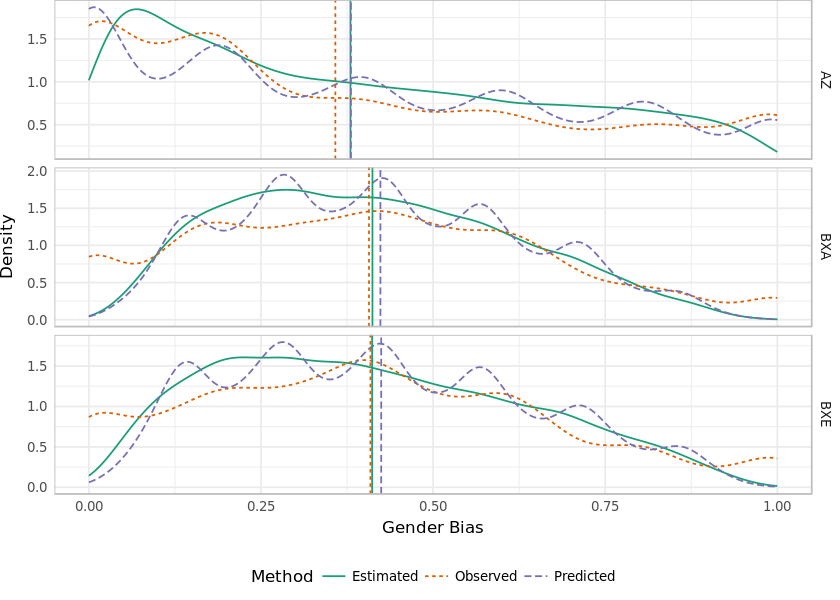

In [112]:
drawplot(file='build/figures/profile-posterior-reclist', width=5, height=2.8, {
    ggplot(profile_result_dens) +
        aes(x=value, y=density, color=Method, linetype=Method) +
        geom_line() +
        geom_vline(data=profile_means, mapping=aes(xintercept=Mean, color=Method, linetype=Method),
                   show.legend=FALSE) +
        facet_grid(Set ~ ., scales = 'free') +
        scale_color_brewer(palette="Dark2") +
        xlab("Gender Bias") + ylab("Density") +
        theme_paper() + theme(legend.position="bottom")
})

## Combine Distribution Plots

Warning message:
“Removed 19 rows containing non-finite values (stat_bin).”

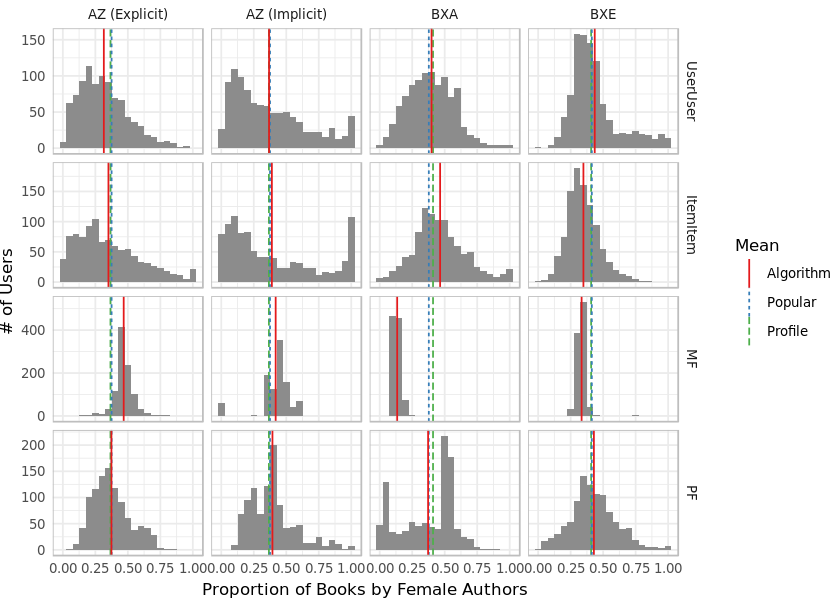

In [14]:
rec_list_hist = ggplot(list_plot_info) +
    aes(x=PropFemale) +
    geom_histogram(binwidth=0.05, fill='grey55') +
    geom_vline(data=rename(plot_means, Mean=Data),
               mapping=aes(xintercept=PropFemale, color=Mean, linetype=Mean)) +
    facet_grid(Algorithm ~ Cond, scales="free_y") +
    xlab("Proportion of Books by Female Authors") +
    ylab("# of Users") +
    scale_colour_brewer(palette="Set1") +
    theme_paper()
rec_list_hist

In [28]:
rec_list_hist_gt = ggplot_gtable(ggplot_build(rec_list_hist))

Warning message:
“Removed 19 rows containing non-finite values (stat_bin).”

In [29]:
rec_list_hist_gt

TableGrob (17 x 16) "layout": 49 grobs
    z         cells       name                                     grob
1   0 ( 1-17, 1-16) background zeroGrob[plot.background..zeroGrob.3855]
2   1 ( 7- 7, 4- 4)  panel-1-1                gTree[panel-1.gTree.3497]
3   1 ( 9- 9, 4- 4)  panel-2-1                gTree[panel-5.gTree.3557]
4   1 (11-11, 4- 4)  panel-3-1                gTree[panel-9.gTree.3617]
5   1 (13-13, 4- 4)  panel-4-1               gTree[panel-13.gTree.3677]
6   1 ( 7- 7, 6- 6)  panel-1-2                gTree[panel-2.gTree.3512]
7   1 ( 9- 9, 6- 6)  panel-2-2                gTree[panel-6.gTree.3572]
8   1 (11-11, 6- 6)  panel-3-2               gTree[panel-10.gTree.3632]
9   1 (13-13, 6- 6)  panel-4-2               gTree[panel-14.gTree.3692]
10  1 ( 7- 7, 8- 8)  panel-1-3                gTree[panel-3.gTree.3527]
11  1 ( 9- 9, 8- 8)  panel-2-3                gTree[panel-7.gTree.3587]
12  1 (11-11, 8- 8)  panel-3-3               gTree[panel-11.gTree.3647]
13  1 (13-13, 8- 8)  pane

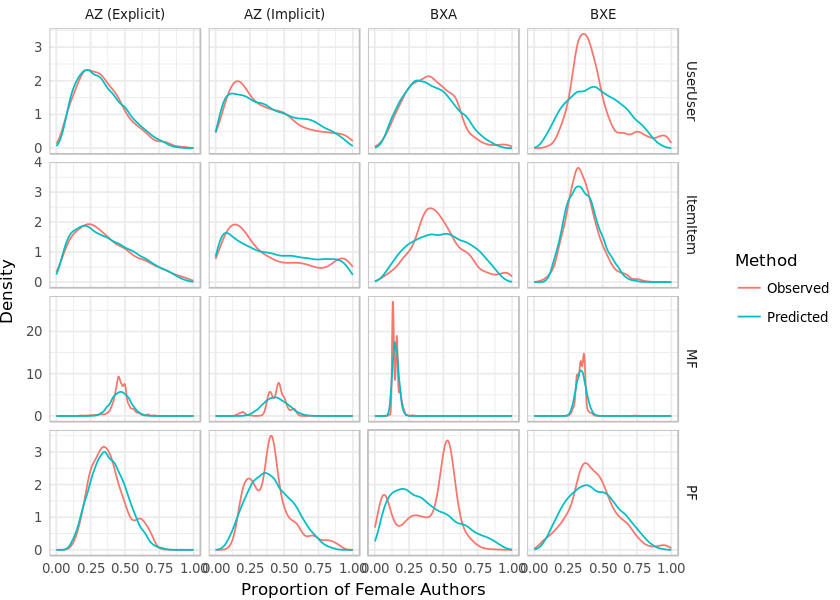

In [34]:
rec_list_post = ggplot(rec_biases) +
    aes(x=value, y=density, color=Method) +
    geom_line() +
    facet_grid(List ~ Cond, scales="free_y") +
    xlab("Proportion of Female Authors") + 
    ylab("Density") +
    theme_paper()
rec_list_post

In [35]:
rec_list_post_gt = ggplot_gtable(ggplot_build(rec_list_post))
rec_list_post_gt

TableGrob (17 x 16) "layout": 49 grobs
    z         cells       name                                     grob
1   0 ( 1-17, 1-16) background zeroGrob[plot.background..zeroGrob.5395]
2   1 ( 7- 7, 4- 4)  panel-1-1                gTree[panel-1.gTree.5041]
3   1 ( 9- 9, 4- 4)  panel-2-1                gTree[panel-5.gTree.5101]
4   1 (11-11, 4- 4)  panel-3-1                gTree[panel-9.gTree.5161]
5   1 (13-13, 4- 4)  panel-4-1               gTree[panel-13.gTree.5221]
6   1 ( 7- 7, 6- 6)  panel-1-2                gTree[panel-2.gTree.5056]
7   1 ( 9- 9, 6- 6)  panel-2-2                gTree[panel-6.gTree.5116]
8   1 (11-11, 6- 6)  panel-3-2               gTree[panel-10.gTree.5176]
9   1 (13-13, 6- 6)  panel-4-2               gTree[panel-14.gTree.5236]
10  1 ( 7- 7, 8- 8)  panel-1-3                gTree[panel-3.gTree.5071]
11  1 ( 9- 9, 8- 8)  panel-2-3                gTree[panel-7.gTree.5131]
12  1 (11-11, 8- 8)  panel-3-3               gTree[panel-11.gTree.5191]
13  1 (13-13, 8- 8)  pane

In [ ]:
save.image("build/RecListModels.rda")